In [662]:
#  한 라이브러리 임포트&설치
# !pip install dbfread
# !pip install haversine
# !pip install sklearn
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine
from tqdm.notebook import tqdm
%matplotlib inline
import platform
import pickle
import re
platform.system()
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
%config InlineBackend.figure_format = 'retina'

In [663]:
def pklopen(route):
    with open('./가공한데이터/{}'.format(route), 'rb') as f:
        df = pickle.load(f)
    return df
def pklsave(df, name):
    with open('{}.pkl'.format(name), 'wb') as f:
        pickle.dump(df, f)

In [664]:
#행정구/동 매칭
dong = pd.read_excel('./data/서울시_행정동_법정동_20200814.xlsx')
#행정동별 거주인구
dong_pop = pklopen('행정동별_거주인구_성별_연령.pickle')
#2015년 결혼상태
married_rate = pd.read_csv('./data/서울시 혼인상태별 인구(15세 이상) 통계.txt', sep='\t')
#맞벌이 가구비율(2012년부터)
both_rate = pd.read_excel('./data/맞벌이 가구비율.xls')
#행정동별 세대수
dong_family = pd.read_csv('./data/행정동별 세대수(17년 12월).txt', sep='\t')
#행정동별 전체인구수
total_ppl = pd.read_pickle('./data/행정동별 전체 인구.pkl')
#귀가시 어른이 맞아주시는 비율
comebackhome = pd.read_csv('./data/귀가_시__부모님_등_어른의_맞이_횟수_20201009190404.csv', encoding='cp949')

In [665]:
# #워킹맘 보고서 2018, 워킹맘 초등학생 자녀 평균 하원, 하교시간
# working_kids = {'4시이전 하원, 하교(%)':[79.6], '4시~5시 하원, 하교(%)':[14.8], '5시이후 하원, 하교(%)':[5.6]}

In [666]:
home_rate_5 = pd.read_csv('./아동 분석_작업중/오후_4시대_오후_4시4시_59분__수업을_마치고_가장_많이_있는_장소_20201009190502.csv', encoding='cp949')
home_rate_7 = pd.read_csv('./아동 분석_작업중/저녁_6시대_저녁_6시6시_59분__수업을_마치고_가장_많이_있는_장소_20201009190539.csv', encoding='cp949')

In [667]:
# working_kids_df = pd.DataFrame(working_kids, index=['초등학생 비율'])
# working_kids_df

# 전처리

### 틈새비율(5시~7시 집에서, 아무도 맞이해주지 못하는 초등학생 비율)

In [668]:
comebackhome = comebackhome.rename(columns=comebackhome.iloc[0]).drop(comebackhome.index[0])
comebackhome['항상 맞이해 주시지 못한다 (%)'] = comebackhome['항상 맞이해 주시지 못한다 (%)'].astype(float)
comebackhome

,특성별(1),특성별(2),사례수 (명),항상 맞이해 주신다 (%),가끔 맞이해 주신다 (%),항상 맞이해 주시지 못한다 (%)
1,전체,소계,8563,66.6,24.3,9.1
2,성별,남자,4318,68.3,23.2,8.4
3,성별,여자,4245,64.8,25.4,9.8
4,교급별,초등1년~초등3년,2847,71.2,19.3,9.4
5,교급별,초등4년~초등6년,2996,63.1,27.7,9.2
6,교급별,중등1년~중등3년,2720,65.4,25.8,8.8
7,지역별,서울,1322,71.1,20.9,8.0
8,지역별,인천/경기,2547,66.2,24.5,9.2
9,지역별,대전/충청/세종/강원,1320,63.3,26.4,10.3
10,지역별,광주/전라/제주,1241,61.3,27.4,11.3


In [669]:
alone_element_rate = comebackhome['항상 맞이해 주시지 못한다 (%)'].iloc[3:5].mean()/100
alone_element_rate

0.09300000000000001

In [670]:
# working_kids_df

In [671]:
# after_five_rate = working_kids_df['5시이후 하원, 하교(%)'].iloc[0]/100
# after_five_rate

In [672]:
# #5시 이후 하원, 하교하는 초등학생 비율 × 귀가 시 집에 아무도 없는 초등학생 비율
# alone_after_five_rate = (alone_element_rate * after_five_rate).round(4)
# alone_after_five_rate

In [673]:
home_rate_5=home_rate_5.rename(columns=home_rate_5.iloc[0]).drop(home_rate_5.index[0])
home_rate_7=home_rate_7.rename(columns=home_rate_7.iloc[0]).drop(home_rate_7.index[0])

In [674]:
home_rate_5['사례수 (명)'] = home_rate_5['사례수 (명)'].astype(float)
home_rate_5['집 (%)'] = home_rate_5['집 (%)'].astype(float)
home_rate_5

,특성별(1),특성별(2),사례수 (명),학교(수업) (%),학교(초등돌봄 방과후 학교) (%),교과목 관련 학원 (%),태권도 도장 (%),예체능 관련 학원 (%),지역 아동센터 방과후 아카데미 (%),도서관 등 공공시설 (%),동네 독서실 공부방 등 (%),동네 주변 놀이터 공원 등 (%),분식점 매점 식당 등 (%),집 (%),기타 (%)
1,전체,소계,8511.0,3.8,4.3,27.6,4.2,9.6,1.6,1.0,1.7,3.8,1.7,36.6,4.1
2,성별,남자,4290.0,3.9,3.9,26.5,5.7,7.5,1.5,0.8,1.7,4.3,1.5,36.8,6.0
3,성별,여자,4221.0,3.7,4.8,28.8,2.6,11.9,1.7,1.2,1.6,3.3,2.0,36.4,2.1
4,교급별,초등1년~초등3년,2809.0,0.4,5.4,16.7,9.6,19.2,2.7,0.9,1.4,5.3,0.6,35.1,2.7
5,교급별,초등4년~초등6년,2996.0,0.6,4.6,42.9,2.1,7.4,1.8,1.0,2.5,4.3,1.2,28.3,3.3
6,교급별,중등1년~중등3년,2706.0,10.3,3.8,23.4,0.6,2.8,0.4,1.1,1.1,1.7,3.1,45.3,6.4
7,지역별,서울,1300.0,2.2,4.8,33.3,2.8,9.4,1.2,1.4,1.1,3.2,1.3,34.3,4.9
8,지역별,인천/경기,2537.0,2.0,3.0,26.7,3.6,10.8,1.5,1.0,1.5,4.7,1.7,39.8,3.5
9,지역별,대전/충청/세종/강원,1312.0,4.7,5.3,23.4,4.7,8.3,2.9,0.7,1.5,3.9,1.4,38.6,4.5
10,지역별,광주/전라/제주,1230.0,6.5,7.6,27.5,5.2,10.9,2.4,1.3,1.8,2.8,2.0,28.5,3.5


In [675]:
home_rate_7['사례수 (명)'] = home_rate_7['사례수 (명)'].astype(float)
home_rate_7['집 (%)'] = home_rate_7['집 (%)'].astype(float)
home_rate_7

,특성별(1),특성별(2),사례수 (명),학교(수업) (%),학교(초등돌봄 방과후 학교) (%),교과목 관련 학원 (%),태권도 도장 (%),예체능 관련 학원 (%),지역 아동센터 방과후 아카데미 (%),도서관 등 공공시설 (%),동네 독서실 공부방 등 (%),동네 주변 놀이터 공원 등 (%),분식점 매점 식당 등 (%),집 (%),기타 (%)
1,전체,소계,8470.0,0.3,0.7,26.7,3.6,5.1,1.0,0.4,1.0,1.5,0.5,56.3,3.0
2,성별,남자,4279.0,0.3,0.8,25.5,4.8,4.8,0.9,0.3,0.8,1.6,0.5,56.0,3.6
3,성별,여자,4191.0,0.2,0.6,28.1,2.4,5.4,1.1,0.4,1.2,1.3,0.4,56.6,2.2
4,교급별,초등1년~초등3년,2789.0,0.1,0.3,4.2,5.1,4.7,1.3,0.3,0.3,1.0,0.3,80.2,2.4
5,교급별,초등4년~초등6년,2992.0,0.2,0.4,22.4,4.8,6.8,1.1,0.6,1.2,2.5,0.6,56.5,2.8
6,교급별,중등1년~중등3년,2689.0,0.6,1.3,53.4,0.8,3.7,0.6,0.4,1.3,0.9,0.5,32.8,3.6
7,지역별,서울,1293.0,0.4,0.5,32.3,3.2,6.3,0.9,0.5,0.6,1.2,0.1,50.0,3.8
8,지역별,인천/경기,2522.0,0.1,0.5,25.5,3.7,6.2,1.0,0.2,1.0,2.0,0.4,56.6,2.9
9,지역별,대전/충청/세종/강원,1308.0,0.5,0.5,22.0,3.3,4.9,1.8,0.6,0.8,1.4,0.8,60.3,3.1
10,지역별,광주/전라/제주,1229.0,0.4,0.6,24.7,3.5,4.1,0.9,0.5,1.0,1.5,0.7,59.4,2.8


In [676]:
#오후 5시 이전에 집에 있는 초등학생 비율
home_5 = ((home_rate_5.iloc[3,2]*home_rate_5.iloc[3,13] + home_rate_5.iloc[4,2]*home_rate_5.iloc[4,13])/(home_rate_5.iloc[3,2]+home_rate_5.iloc[4,2]))/100
home_5

0.315904737295435

In [677]:
#오후 7시 이전에 집에 있는 초등학생 비율
home_7 = ((home_rate_7.iloc[3,2]*home_rate_7.iloc[3,13] + home_rate_7.iloc[4,2]*home_rate_7.iloc[4,13])/(home_rate_7.iloc[3,2]+home_rate_7.iloc[4,2]))/100
home_7

0.6793388687078361

In [678]:
#5시에서 집에 도착해서 7시까지 집에 있는 초등학생의 비율
home_5_7 = (home_7 - home_5)
home_5_7

0.3634341314124011

In [696]:
AR = alone_element_rate * home_5_7
AR

0.03379937422135331

### 동별 3040대 맞벌이 부부 & 결혼율 & 동별 0514인구 반영 돌봄 지수

In [679]:
#동별 코드/구 매칭자료(후에 라벨링에서 사용 됨)
dong = dong[dong['시도명']=='서울특별시']
dong_df = dong[['행정동코드','시군구명']].dropna().drop_duplicates()
dong_df['행정동코드'] = dong_df['행정동코드'].astype(str)


dong_df

,행정동코드,시군구명
1,1111000000,종로구
2,1111051500,종로구
12,1111053000,종로구
24,1111054000,종로구
31,1111055000,종로구
...,...,...
763,1174065000,강동구
764,1174066000,강동구
765,1174068500,강동구
766,1174069000,강동구


In [680]:
dong_pop

,ADMI_CD,ADMI_NM,5559세_2,5559세_1,5054세_1,5054세_2,4549세_1,4549세_2,4044세_1,4044세_2,...,2529세_1,2529세_2,2024세_1,2024세_2,1519세_1,1519세_2,1014세_1,1014세_2,0509세_2,0509세_1
1725910,1117051000,후암동,757,709,722,763,745,782,601,653,...,783,748,540,524,422,330,310,270,266,299
1725912,1159053000,상도1동,1691,1439,1535,1723,1716,1678,1616,1657,...,2631,2201,2346,2649,977,908,792,773,839,880
1725913,1111070000,숭인1동,288,305,254,293,292,258,216,202,...,228,225,184,179,102,114,85,92,94,98
1725917,1111061500,종로1.2.3.4가동,251,549,431,164,341,218,242,157,...,308,212,142,195,59,66,58,41,46,54
1725919,1117057000,원효로2동,547,586,569,634,633,640,530,576,...,501,530,385,471,292,440,230,341,267,271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1728432,1153059500,가리봉동,425,592,589,369,411,338,284,210,...,498,368,257,283,96,99,72,56,65,74
1728436,1156055000,당산1동,783,774,783,756,799,718,754,701,...,1087,1256,552,708,300,301,220,212,274,253
1728438,1141072000,북가좌2동,1486,1272,1390,1399,1383,1438,1147,1191,...,1373,1310,1116,1110,768,726,544,525,477,547
1728439,1165062000,방배3동,1024,856,838,916,852,1027,686,786,...,805,720,714,688,666,547,393,460,368,396


In [681]:
#동별 타겟나이 전처리
dong_pop.reset_index(inplace=True)
del dong_pop['index']
dong_pop.columns = ['행정동코드', '행정동명', '5559세_(여)', '5559세_(남)', '5054세_(남)', '5054세_(여)',
       '4549세_(남)', '4549세_(여)', '4044세_(남)', '4044세_(여)', '3539세_(남)', '3539세_(여)',
       '3034세_(남)', '3034세_(여)', '2529세_(남)', '2529세_(여)', '2024세_(남)', '2024세_(여)',
       '1519세_(남)', '1519세_(여)', '1014세_(남)', '1014세_(여)', '0509세_(여)', '0509세_(남)']
dong_pop['0514세 인구'] = dong_pop['0509세_(남)'] + dong_pop['0509세_(여)'] + dong_pop['1014세_(남)']+dong_pop['1014세_(여)']
dong_pop['30대 인구'] = dong_pop['3034세_(남)'] + dong_pop['3034세_(여)'] + dong_pop['3539세_(남)'] + dong_pop['3539세_(여)']
dong_pop['40대 인구'] = dong_pop['4044세_(남)'] + dong_pop['4044세_(여)'] + dong_pop['4549세_(남)'] + dong_pop['4549세_(여)']
#특수문자 차이로 인한 nan값 발생 방지
dong_pop = dong_pop.replace({'행정동명': '종로5.6가동'}, {'행정동명': '종로5·6가동'})

dong_pop

,행정동코드,행정동명,5559세_(여),5559세_(남),5054세_(남),5054세_(여),4549세_(남),4549세_(여),4044세_(남),4044세_(여),...,2024세_(여),1519세_(남),1519세_(여),1014세_(남),1014세_(여),0509세_(여),0509세_(남),0514세 인구,30대 인구,40대 인구
0,1117051000,후암동,757,709,722,763,745,782,601,653,...,524,422,330,310,270,266,299,1145,2846,2781
1,1159053000,상도1동,1691,1439,1535,1723,1716,1678,1616,1657,...,2649,977,908,792,773,839,880,3284,6458,6667
2,1111070000,숭인1동,288,305,254,293,292,258,216,202,...,179,102,114,85,92,94,98,369,845,968
3,1111061500,종로1.2.3.4가동,251,549,431,164,341,218,242,157,...,195,59,66,58,41,46,54,199,905,958
4,1117057000,원효로2동,547,586,569,634,633,640,530,576,...,471,292,440,230,341,267,271,1109,2087,2379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,1153059500,가리봉동,425,592,589,369,411,338,284,210,...,283,96,99,72,56,65,74,267,1219,1243
420,1156055000,당산1동,783,774,783,756,799,718,754,701,...,708,300,301,220,212,274,253,959,4228,2972
421,1141072000,북가좌2동,1486,1272,1390,1399,1383,1438,1147,1191,...,1110,768,726,544,525,477,547,2093,4444,5159
422,1165062000,방배3동,1024,856,838,916,852,1027,686,786,...,688,666,547,393,460,368,396,1617,3049,3351


In [682]:
#동별 타겟나이  분만 추리기
dong_pop_need = dong_pop[['행정동코드','행정동명','0514세 인구','30대 인구','40대 인구']]
dong_pop_need['행정동코드']=dong_pop_need['행정동코드'].astype(str)
dong_pop_need['0514세 인구']=dong_pop_need['0514세 인구'].astype(int)
dong_pop_need['30대 인구']=dong_pop_need['30대 인구'].astype(int)
dong_pop_need['40대 인구']=dong_pop_need['40대 인구'].astype(int)
dong_pop_need['3040세 인구'] = dong_pop_need['30대 인구'] + dong_pop_need['40대 인구']

del dong_pop_need['30대 인구']
del dong_pop_need['40대 인구']

#구 라벨링
pop_df = pd.merge(dong_pop_need, dong_df, on='행정동코드')
pop_df

<ipython-input-682-42a8e2cdcf14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dong_pop_need['행정동코드']=dong_pop_need['행정동코드'].astype(str)
<ipython-input-682-42a8e2cdcf14>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dong_pop_need['0514세 인구']=dong_pop_need['0514세 인구'].astype(int)
<ipython-input-682-42a8e2cdcf14>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

,행정동코드,행정동명,0514세 인구,3040세 인구,시군구명
0,1117051000,후암동,1145,5627,용산구
1,1159053000,상도1동,3284,13125,동작구
2,1111070000,숭인1동,369,1813,종로구
3,1111061500,종로1.2.3.4가동,199,1863,종로구
4,1117057000,원효로2동,1109,4466,용산구
...,...,...,...,...,...
419,1153059500,가리봉동,267,2462,구로구
420,1156055000,당산1동,959,7200,영등포구
421,1141072000,북가좌2동,2093,9603,서대문구
422,1165062000,방배3동,1617,6400,서초구


In [683]:
#결혼율 전처리
married_rate = married_rate.rename(columns=married_rate.iloc[1]).drop(married_rate.index[:2])
married_rate_need = married_rate.iloc[:, :7]
del married_rate_need['기간']
married_rate_need.계 = married_rate_need.계.apply(lambda x: re.sub(',','', x))#.astype(int)
married_rate_need.유배우 = married_rate_need.유배우.apply(lambda x: re.sub(',','', x))#.astype(int)
married_rate_need.사별 = married_rate_need.사별.apply(lambda x: re.sub(',','', x))#.astype(int)
married_rate_need.이혼 = married_rate_need.이혼.apply(lambda x: re.sub(',','', x))#.astype(int)

married_rate_need.계 = married_rate_need.계.apply(lambda x: re.sub('-','0', x)).astype(int)
married_rate_need.유배우 = married_rate_need.유배우.apply(lambda x: re.sub('-','0', x)).astype(int)
married_rate_need.사별 = married_rate_need.사별.apply(lambda x: re.sub('-','0', x)).astype(int)
married_rate_need.이혼 = married_rate_need.이혼.apply(lambda x: re.sub('-','0', x)).astype(int)

married_rate_need

C:\anaconda3\lib\site-packages\pandas\core\generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,자치구,연령별,계,유배우,사별,이혼
2,합계,합계,8393832,4481669,519388,417869
3,합계,15~19,543220,305,83,17
4,합계,20~24,681323,6832,243,397
5,합계,25~29,721164,76824,200,1490
6,합계,30~34,821484,352439,403,7422
...,...,...,...,...,...,...
413,강동구,65~69,19697,15001,3021,1473
414,강동구,70~74,13382,9120,3359,740
415,강동구,75~79,8294,4568,3338,302
416,강동구,80~84,4802,1726,2885,147


In [684]:
#구별 연령별 결혼율
age30=married_rate_need['연령별'] == '30~34'
age35=married_rate_need['연령별'] == '35~39'
age40=married_rate_need['연령별'] == '40~44'
age45=married_rate_need['연령별'] == '45~49'
age_need = pd.concat([married_rate_need[age30].iloc[:,0].reset_index(), married_rate_need[age30].iloc[:,2:].reset_index() + married_rate_need[age35].iloc[:,2:].reset_index() + married_rate_need[age40].iloc[:,2:].reset_index() + married_rate_need[age45].iloc[:,2:].reset_index()], axis=1)
del age_need['index']
age_need['결혼율'] = (age_need['유배우']/age_need['계'])
married_rate_gu_df = age_need[['자치구','결혼율']]
married_rate_gu_df.columns = ['시군구명','3040대 결혼율']
married_rate_gu_df

,시군구명,3040대 결혼율
0,합계,0.634570
1,종로구,0.588887
2,중구,0.557223
3,용산구,0.593661
4,성동구,0.628100
5,광진구,0.593863
6,동대문구,0.604736
7,중랑구,0.598189
8,성북구,0.662632
9,강북구,0.575451


In [685]:
pop_df

,행정동코드,행정동명,0514세 인구,3040세 인구,시군구명
0,1117051000,후암동,1145,5627,용산구
1,1159053000,상도1동,3284,13125,동작구
2,1111070000,숭인1동,369,1813,종로구
3,1111061500,종로1.2.3.4가동,199,1863,종로구
4,1117057000,원효로2동,1109,4466,용산구
...,...,...,...,...,...
419,1153059500,가리봉동,267,2462,구로구
420,1156055000,당산1동,959,7200,영등포구
421,1141072000,북가좌2동,2093,9603,서대문구
422,1165062000,방배3동,1617,6400,서초구


In [686]:
total_df = pop_df[['행정동코드','행정동명','시군구명','0514세 인구','3040세 인구']]
total_df['행정동코드'] = total_df['행정동코드'].astype(str)
total_df

,행정동코드,행정동명,시군구명,0514세 인구,3040세 인구
0,1117051000,후암동,용산구,1145,5627
1,1159053000,상도1동,동작구,3284,13125
2,1111070000,숭인1동,종로구,369,1813
3,1111061500,종로1.2.3.4가동,종로구,199,1863
4,1117057000,원효로2동,용산구,1109,4466
...,...,...,...,...,...
419,1153059500,가리봉동,구로구,267,2462
420,1156055000,당산1동,영등포구,959,7200
421,1141072000,북가좌2동,서대문구,2093,9603
422,1165062000,방배3동,서초구,1617,6400


In [687]:
#연령별 맞벌이 가구 비율
both_rate = both_rate.rename(columns=both_rate.iloc[2]).drop(both_rate.index[2]).fillna(0)
both_rate.reset_index(inplace=True)
both_rate.columns = ['index','연령','유배우가구', '맞벌이가구', '비율', '유배우가구', '맞벌이가구', '비율',
    '유배우가구', '맞벌이가구','비율', '유배우가구', '맞벌이가구', '비율', '유배우가구', '맞벌이가구',
    '비율', '유배우가구', '맞벌이가구', '비율', '유배우가구', '맞벌이가구', '비율', '유배우가구',
    '맞벌이가구', '비율'] 

both_rate_need = pd.concat([both_rate.연령, both_rate.iloc[:,-9:]], axis=1)
both_rate_need.columns=['연령','유배우가구(2016)','맞벌이가구(2016)','비율(2016)','유배우가구(2017)','맞벌이가구(2017)','비율(2017)','유배우가구(2018)','맞벌이가구(2018)', '비율(2018)']
both_rate_df = both_rate_need[['연령','유배우가구(2017)','맞벌이가구(2017)','비율(2017)']].iloc[2:8]
both_rate_df['유배우가구(2017)'] = pd.to_numeric(both_rate_df['유배우가구(2017)'].astype(str).apply(lambda x: re.sub(',','', x)))
both_rate_df['맞벌이가구(2017)'] = pd.to_numeric(both_rate_df['맞벌이가구(2017)'].astype(str).apply(lambda x: re.sub(',','', x)))
both_rate_df['비율(2017)'] = pd.to_numeric(both_rate_df['비율(2017)'].astype(str).apply(lambda x: re.sub(',','', x)))/100
both_rate_df

,연령,유배우가구(2017),맞벌이가구(2017),비율(2017)
2,전체,12224,5456,0.446
3,15~29세,179,66,0.368
4,30~39세,2015,954,0.473
5,40~49세,3175,1655,0.521
6,50~64세,4604,2240,0.487
7,65세 이상,2251,542,0.241


In [688]:
total_ppl.columns = ['행정동코드','행정동명','시군구명','총거주인구']
total_ppl['행정동코드'] = total_ppl['행정동코드'] + '00'
total_ppl.reset_index(inplace=True)
del total_ppl['index']

#특수문자 차이로 인한 nan값 발생 방지
total_ppl = total_ppl.replace({'행정동명': '종로5.6가동'}, {'행정동명': '종로5·6가동'})

total_ppl[total_ppl.행정동명=='종로5·6가동']

,행정동코드,행정동명,시군구명,총거주인구
221,1111063000,종로5·6가동,종로구,5340


In [689]:
whole_df = pd.merge(total_df, total_ppl, on=['행정동명','시군구명','행정동코드'])
whole_df = whole_df[['행정동코드','시군구명','행정동명','0514세 인구','3040세 인구','총거주인구']]
final_df = pd.merge(whole_df, married_rate_gu_df, on='시군구명')
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,총거주인구,3040대 결혼율
0,1117051000,용산구,후암동,1145,5627,17804,0.593661
1,1117057000,용산구,원효로2동,1109,4466,14336,0.593661
2,1117064000,용산구,이촌2동,493,2770,8820,0.593661
3,1117066000,용산구,이태원2동,452,3103,9272,0.593661
4,1117069000,용산구,서빙고동,1180,4071,13353,0.593661
...,...,...,...,...,...,...,...
419,1120072000,성동구,송정동,556,3308,10945,0.628100
420,1120067000,성동구,성수2가1동,868,5104,17003,0.628100
421,1120053500,성동구,왕십리도선동,1980,8933,27276,0.628100
422,1120064500,성동구,옥수동,2138,9738,26909,0.628100


# 결혼율과 3~40대 인구 곱 

In [690]:
final_df['3040세 기혼인구'] = final_df['3040세 인구'] * final_df['3040대 결혼율']
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,총거주인구,3040대 결혼율,3040세 기혼인구
0,1117051000,용산구,후암동,1145,5627,17804,0.593661,3340.529908
1,1117057000,용산구,원효로2동,1109,4466,14336,0.593661,2651.289598
2,1117064000,용산구,이촌2동,493,2770,8820,0.593661,1644.440705
3,1117066000,용산구,이태원2동,452,3103,9272,0.593661,1842.129786
4,1117069000,용산구,서빙고동,1180,4071,13353,0.593661,2416.793541
...,...,...,...,...,...,...,...,...
419,1120072000,성동구,송정동,556,3308,10945,0.628100,2077.756347
420,1120067000,성동구,성수2가1동,868,5104,17003,0.628100,3205.824787
421,1120053500,성동구,왕십리도선동,1980,8933,27276,0.628100,5610.821478
422,1120064500,성동구,옥수동,2138,9738,26909,0.628100,6116.442354


In [691]:
#맞벌이 비율 곱하기
both_30s = both_rate_df.iloc[2,3]
both_40s = both_rate_df.iloc[3,3]
both_3040s = (both_30s + both_40s)/2
both_3040s


0.497

In [692]:
final_df['3040세 맞벌이 기혼인구'] = (final_df['3040세 기혼인구']*both_3040s)
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 맞벌이 기혼인구
0,1117051000,용산구,후암동,1145,5627,17804,0.593661,3340.529908,1660.243364
1,1117057000,용산구,원효로2동,1109,4466,14336,0.593661,2651.289598,1317.690930
2,1117064000,용산구,이촌2동,493,2770,8820,0.593661,1644.440705,817.287030
3,1117066000,용산구,이태원2동,452,3103,9272,0.593661,1842.129786,915.538504
4,1117069000,용산구,서빙고동,1180,4071,13353,0.593661,2416.793541,1201.146390
...,...,...,...,...,...,...,...,...,...
419,1120072000,성동구,송정동,556,3308,10945,0.628100,2077.756347,1032.644905
420,1120067000,성동구,성수2가1동,868,5104,17003,0.628100,3205.824787,1593.294919
421,1120053500,성동구,왕십리도선동,1980,8933,27276,0.628100,5610.821478,2788.578274
422,1120064500,성동구,옥수동,2138,9738,26909,0.628100,6116.442354,3039.871850


In [693]:
# final_df['3040세 세대별 맞벌이 기혼비율지수(맞벌이 기혼인구/2인이상세대수)'] = 100*(final_df['3040세 맞벌이 기혼인구']/final_df['2인이상세대수']).round(2)
final_df['행정동별 3040세 맞벌이 기혼인구 비율'] = final_df['3040세 맞벌이 기혼인구']/final_df['총거주인구']
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 맞벌이 기혼인구,행정동별 3040세 맞벌이 기혼인구 비율
0,1117051000,용산구,후암동,1145,5627,17804,0.593661,3340.529908,1660.243364,0.093251
1,1117057000,용산구,원효로2동,1109,4466,14336,0.593661,2651.289598,1317.690930,0.091915
2,1117064000,용산구,이촌2동,493,2770,8820,0.593661,1644.440705,817.287030,0.092663
3,1117066000,용산구,이태원2동,452,3103,9272,0.593661,1842.129786,915.538504,0.098742
4,1117069000,용산구,서빙고동,1180,4071,13353,0.593661,2416.793541,1201.146390,0.089953
...,...,...,...,...,...,...,...,...,...,...
419,1120072000,성동구,송정동,556,3308,10945,0.628100,2077.756347,1032.644905,0.094349
420,1120067000,성동구,성수2가1동,868,5104,17003,0.628100,3205.824787,1593.294919,0.093707
421,1120053500,성동구,왕십리도선동,1980,8933,27276,0.628100,5610.821478,2788.578274,0.102236
422,1120064500,성동구,옥수동,2138,9738,26909,0.628100,6116.442354,3039.871850,0.112969


In [694]:
# final_df['초등돌봄 지수(세대별)'] = final_df['3040세 세대별 맞벌이 기혼비율지수(맞벌이 기혼인구/2인이상세대수)']*final_df['0514세 인구']
final_df['초등돌봄필요 인구'] = final_df['0514세 인구']*final_df['행정동별 3040세 맞벌이 기혼인구 비율']
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 맞벌이 기혼인구,행정동별 3040세 맞벌이 기혼인구 비율,초등돌봄필요 인구
0,1117051000,용산구,후암동,1145,5627,17804,0.593661,3340.529908,1660.243364,0.093251,106.772560
1,1117057000,용산구,원효로2동,1109,4466,14336,0.593661,2651.289598,1317.690930,0.091915,101.933541
2,1117064000,용산구,이촌2동,493,2770,8820,0.593661,1644.440705,817.287030,0.092663,45.682824
3,1117066000,용산구,이태원2동,452,3103,9272,0.593661,1842.129786,915.538504,0.098742,44.631515
4,1117069000,용산구,서빙고동,1180,4071,13353,0.593661,2416.793541,1201.146390,0.089953,106.144892
...,...,...,...,...,...,...,...,...,...,...,...
419,1120072000,성동구,송정동,556,3308,10945,0.628100,2077.756347,1032.644905,0.094349,52.457795
420,1120067000,성동구,성수2가1동,868,5104,17003,0.628100,3205.824787,1593.294919,0.093707,81.337410
421,1120053500,성동구,왕십리도선동,1980,8933,27276,0.628100,5610.821478,2788.578274,0.102236,202.426492
422,1120064500,성동구,옥수동,2138,9738,26909,0.628100,6116.442354,3039.871850,0.112969,241.526850


# 틈새비율 * 초등돌봄 지수(인구별)

In [697]:
final_df['돌봄 틈새공백 인구'] = final_df['초등돌봄필요 인구'] * AR
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 맞벌이 기혼인구,행정동별 3040세 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구
0,1117051000,용산구,후암동,1145,5627,17804,0.593661,3340.529908,1660.243364,0.093251,106.772560,3.608846
1,1117057000,용산구,원효로2동,1109,4466,14336,0.593661,2651.289598,1317.690930,0.091915,101.933541,3.445290
2,1117064000,용산구,이촌2동,493,2770,8820,0.593661,1644.440705,817.287030,0.092663,45.682824,1.544051
3,1117066000,용산구,이태원2동,452,3103,9272,0.593661,1842.129786,915.538504,0.098742,44.631515,1.508517
4,1117069000,용산구,서빙고동,1180,4071,13353,0.593661,2416.793541,1201.146390,0.089953,106.144892,3.587631
...,...,...,...,...,...,...,...,...,...,...,...,...
419,1120072000,성동구,송정동,556,3308,10945,0.628100,2077.756347,1032.644905,0.094349,52.457795,1.773041
420,1120067000,성동구,성수2가1동,868,5104,17003,0.628100,3205.824787,1593.294919,0.093707,81.337410,2.749154
421,1120053500,성동구,왕십리도선동,1980,8933,27276,0.628100,5610.821478,2788.578274,0.102236,202.426492,6.841889
422,1120064500,성동구,옥수동,2138,9738,26909,0.628100,6116.442354,3039.871850,0.112969,241.526850,8.163456


In [698]:
final_df['동별 돌봄 틈새공백 인구 비율'] = final_df['돌봄 틈새공백 인구'] /final_df['0514세 인구']
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 맞벌이 기혼인구,행정동별 3040세 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구,동별 돌봄 틈새공백 인구 비율
0,1117051000,용산구,후암동,1145,5627,17804,0.593661,3340.529908,1660.243364,0.093251,106.772560,3.608846,0.003152
1,1117057000,용산구,원효로2동,1109,4466,14336,0.593661,2651.289598,1317.690930,0.091915,101.933541,3.445290,0.003107
2,1117064000,용산구,이촌2동,493,2770,8820,0.593661,1644.440705,817.287030,0.092663,45.682824,1.544051,0.003132
3,1117066000,용산구,이태원2동,452,3103,9272,0.593661,1842.129786,915.538504,0.098742,44.631515,1.508517,0.003337
4,1117069000,용산구,서빙고동,1180,4071,13353,0.593661,2416.793541,1201.146390,0.089953,106.144892,3.587631,0.003040
...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,1120072000,성동구,송정동,556,3308,10945,0.628100,2077.756347,1032.644905,0.094349,52.457795,1.773041,0.003189
420,1120067000,성동구,성수2가1동,868,5104,17003,0.628100,3205.824787,1593.294919,0.093707,81.337410,2.749154,0.003167
421,1120053500,성동구,왕십리도선동,1980,8933,27276,0.628100,5610.821478,2788.578274,0.102236,202.426492,6.841889,0.003455
422,1120064500,성동구,옥수동,2138,9738,26909,0.628100,6116.442354,3039.871850,0.112969,241.526850,8.163456,0.003818


<AxesSubplot:xlabel='동별 돌봄 틈새공백 인구 비율', ylabel='Count'>

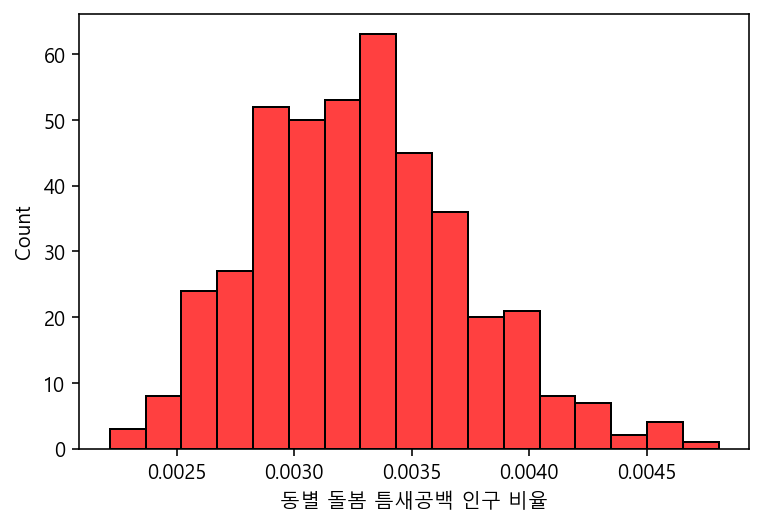

In [699]:
sns.histplot(final_df['동별 돌봄 틈새공백 인구 비율'], color='red')

<AxesSubplot:>

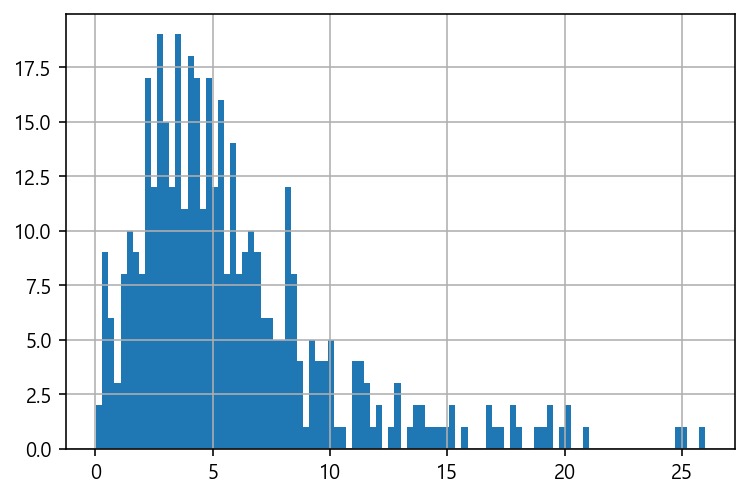

In [700]:
final_df['돌봄 틈새공백 인구'].hist(bins=100)

{'whiskers': [<matplotlib.lines.Line2D at 0x1b5393f26a0>,
 'caps': [<matplotlib.lines.Line2D at 0x1b532be7130>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b5393f2fa0>],
 'medians': [<matplotlib.lines.Line2D at 0x1b532be7550>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b532be7c40>],
 'means': []}

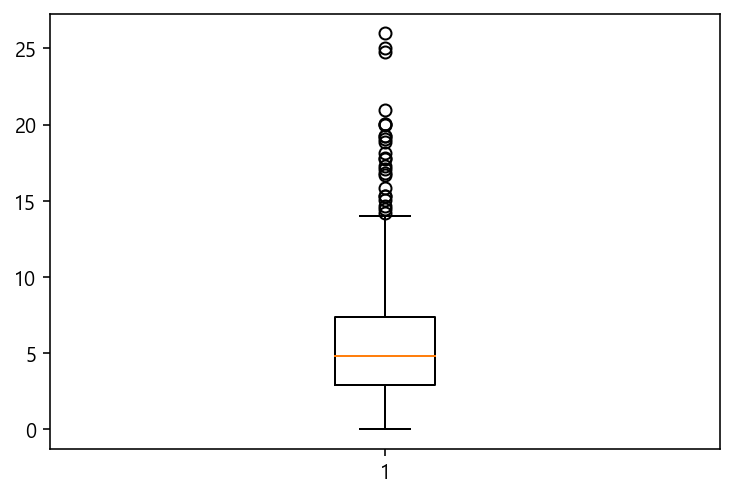

In [701]:
plt.boxplot(final_df['돌봄 틈새공백 인구'])

In [702]:
final_df.sort_values(by='돌봄 틈새공백 인구',ascending=False)

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 맞벌이 기혼인구,행정동별 3040세 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구,동별 돌봄 틈새공백 인구 비율
266,1171067000,송파구,잠실2동,6297,13331,36636,0.675025,8998.755850,4472.381658,0.122076,768.713487,25.982035,0.004126
82,1147055000,양천구,목5동,6591,13560,42628,0.710399,9633.008228,4787.605089,0.112311,740.243623,25.019771,0.003796
390,1138069000,은평구,진관동,7384,18196,57622,0.632888,11516.028168,5723.465999,0.099328,733.436412,24.789692,0.003357
356,1129066000,성북구,길음1동,5305,13021,36678,0.662632,8628.125645,4288.178446,0.116914,620.229747,20.963377,0.003952
191,1165065100,서초구,양재1동,5145,14942,45147,0.701256,10478.170428,5207.650703,0.115349,593.469397,20.058894,0.003899
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44,1111067000,종로구,창신1동,174,1192,5164,0.588887,701.953750,348.871014,0.067558,11.755143,0.397316,0.002283
41,1111063000,종로구,종로5·6가동,146,1333,5340,0.588887,784.986870,390.138474,0.073060,10.666707,0.360528,0.002469
54,1114055000,중구,명동,124,841,2999,0.557223,468.624765,232.906508,0.077661,9.630012,0.325488,0.002625
56,1114060500,중구,을지로동,44,481,1830,0.557223,268.024390,133.208122,0.072791,3.202818,0.108253,0.002460


# pt 하기

In [703]:
pt_list = np.percentile(final_df[['돌봄 틈새공백 인구']],[i*10 for i in range(1,10)]).tolist()
pt_list

[1.7318552296576182,
 2.6323318581724715,
 3.3431932510345543,
 4.05056915362848,
 4.83630112673031,
 5.567204677795376,
 6.731559790975027,
 8.209358656416285,
 11.214163295069806]

In [704]:
# 초등돌봄틈새 분위 라벨링
final_df['돌봄틈새공백 분위'] = 0
final_df.loc[final_df['돌봄 틈새공백 인구'] <= pt_list[0], '돌봄틈새공백 분위'] = 10
final_df.loc[(final_df['돌봄 틈새공백 인구'] > pt_list[0]) & (final_df['돌봄 틈새공백 인구'] <= pt_list[1]),'돌봄틈새공백 분위'] = 9
final_df.loc[(final_df['돌봄 틈새공백 인구'] > pt_list[1]) & (final_df['돌봄 틈새공백 인구'] <= pt_list[2]),'돌봄틈새공백 분위'] = 8
final_df.loc[(final_df['돌봄 틈새공백 인구'] > pt_list[2]) & (final_df['돌봄 틈새공백 인구'] <= pt_list[3]),'돌봄틈새공백 분위'] = 7
final_df.loc[(final_df['돌봄 틈새공백 인구'] > pt_list[3]) & (final_df['돌봄 틈새공백 인구'] <= pt_list[4]),'돌봄틈새공백 분위'] = 6
final_df.loc[(final_df['돌봄 틈새공백 인구'] > pt_list[4]) & (final_df['돌봄 틈새공백 인구'] <= pt_list[5]),'돌봄틈새공백 분위'] = 5
final_df.loc[(final_df['돌봄 틈새공백 인구'] > pt_list[5]) & (final_df['돌봄 틈새공백 인구'] <= pt_list[6]),'돌봄틈새공백 분위'] = 4
final_df.loc[(final_df['돌봄 틈새공백 인구'] > pt_list[6]) & (final_df['돌봄 틈새공백 인구'] <= pt_list[7]),'돌봄틈새공백 분위'] = 3
final_df.loc[(final_df['돌봄 틈새공백 인구'] > pt_list[7]) & (final_df['돌봄 틈새공백 인구'] <= pt_list[8]),'돌봄틈새공백 분위'] = 2
final_df.loc[(final_df['돌봄 틈새공백 인구'] > pt_list[8]),'돌봄틈새공백 분위'] = 1
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 맞벌이 기혼인구,행정동별 3040세 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구,동별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
0,1117051000,용산구,후암동,1145,5627,17804,0.593661,3340.529908,1660.243364,0.093251,106.772560,3.608846,0.003152,7
1,1117057000,용산구,원효로2동,1109,4466,14336,0.593661,2651.289598,1317.690930,0.091915,101.933541,3.445290,0.003107,7
2,1117064000,용산구,이촌2동,493,2770,8820,0.593661,1644.440705,817.287030,0.092663,45.682824,1.544051,0.003132,10
3,1117066000,용산구,이태원2동,452,3103,9272,0.593661,1842.129786,915.538504,0.098742,44.631515,1.508517,0.003337,10
4,1117069000,용산구,서빙고동,1180,4071,13353,0.593661,2416.793541,1201.146390,0.089953,106.144892,3.587631,0.003040,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,1120072000,성동구,송정동,556,3308,10945,0.628100,2077.756347,1032.644905,0.094349,52.457795,1.773041,0.003189,9
420,1120067000,성동구,성수2가1동,868,5104,17003,0.628100,3205.824787,1593.294919,0.093707,81.337410,2.749154,0.003167,8
421,1120053500,성동구,왕십리도선동,1980,8933,27276,0.628100,5610.821478,2788.578274,0.102236,202.426492,6.841889,0.003455,3
422,1120064500,성동구,옥수동,2138,9738,26909,0.628100,6116.442354,3039.871850,0.112969,241.526850,8.163456,0.003818,3


In [705]:
alone_need_df = final_df[['행정동코드','시군구명','행정동명','돌봄 틈새공백 인구','동별 돌봄 틈새공백 인구 비율','돌봄틈새공백 분위']]
alone_need_df

,행정동코드,시군구명,행정동명,돌봄 틈새공백 인구,동별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
0,1117051000,용산구,후암동,3.608846,0.003152,7
1,1117057000,용산구,원효로2동,3.445290,0.003107,7
2,1117064000,용산구,이촌2동,1.544051,0.003132,10
3,1117066000,용산구,이태원2동,1.508517,0.003337,10
4,1117069000,용산구,서빙고동,3.587631,0.003040,7
...,...,...,...,...,...,...
419,1120072000,성동구,송정동,1.773041,0.003189,9
420,1120067000,성동구,성수2가1동,2.749154,0.003167,8
421,1120053500,성동구,왕십리도선동,6.841889,0.003455,3
422,1120064500,성동구,옥수동,8.163456,0.003818,3


In [706]:
alone_need_df[alone_need_df['돌봄틈새공백 분위']==10].groupby('시군구명').count()

,행정동코드,행정동명,돌봄 틈새공백 인구,동별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
시군구명,,,,,
강남구,2,2,2,2,2
강동구,1,1,1,1,1
강서구,1,1,1,1,1
관악구,2,2,2,2,2
광진구,1,1,1,1,1
구로구,1,1,1,1,1
금천구,1,1,1,1,1
동대문구,1,1,1,1,1
동작구,1,1,1,1,1


In [707]:
alone_need_df.to_pickle('최종 돌봄 틈새공백 인구.pkl')
alone_need_df.to_csv('최종 돌봄 틈새공백 인구.csv')

In [708]:
alone_need_df

,행정동코드,시군구명,행정동명,돌봄 틈새공백 인구,동별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
0,1117051000,용산구,후암동,3.608846,0.003152,7
1,1117057000,용산구,원효로2동,3.445290,0.003107,7
2,1117064000,용산구,이촌2동,1.544051,0.003132,10
3,1117066000,용산구,이태원2동,1.508517,0.003337,10
4,1117069000,용산구,서빙고동,3.587631,0.003040,7
...,...,...,...,...,...,...
419,1120072000,성동구,송정동,1.773041,0.003189,9
420,1120067000,성동구,성수2가1동,2.749154,0.003167,8
421,1120053500,성동구,왕십리도선동,6.841889,0.003455,3
422,1120064500,성동구,옥수동,8.163456,0.003818,3


In [644]:
temp_df = alone_need_df[['행정동명','시군구명','돌봄 틈새공백 인구','동별 돌봄 틈새공백 인구 비율', '돌봄틈새공백 분위']]
temp_df

,행정동명,시군구명,돌봄 틈새공백 인구,동별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
0,후암동,용산구,38.804792,0.033891,7
1,원효로2동,용산구,37.046128,0.033405,7
2,이촌2동,용산구,16.602697,0.033677,10
3,이태원2동,용산구,16.220616,0.035886,10
4,서빙고동,용산구,38.576677,0.032692,7
...,...,...,...,...,...
419,송정동,성동구,19.064953,0.034289,9
420,성수2가1동,성동구,29.560791,0.034056,8
421,왕십리도선동,성동구,73.568696,0.037156,3
422,옥수동,성동구,87.779101,0.041057,3


In [645]:
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 맞벌이 기혼인구,행정동별 3040세 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구,동별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
0,1117051000,용산구,후암동,1145,5627,17804,0.593661,3340.529908,1660.243364,0.093251,106.772560,38.804792,0.033891,7
1,1117057000,용산구,원효로2동,1109,4466,14336,0.593661,2651.289598,1317.690930,0.091915,101.933541,37.046128,0.033405,7
2,1117064000,용산구,이촌2동,493,2770,8820,0.593661,1644.440705,817.287030,0.092663,45.682824,16.602697,0.033677,10
3,1117066000,용산구,이태원2동,452,3103,9272,0.593661,1842.129786,915.538504,0.098742,44.631515,16.220616,0.035886,10
4,1117069000,용산구,서빙고동,1180,4071,13353,0.593661,2416.793541,1201.146390,0.089953,106.144892,38.576677,0.032692,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,1120072000,성동구,송정동,556,3308,10945,0.628100,2077.756347,1032.644905,0.094349,52.457795,19.064953,0.034289,9
420,1120067000,성동구,성수2가1동,868,5104,17003,0.628100,3205.824787,1593.294919,0.093707,81.337410,29.560791,0.034056,8
421,1120053500,성동구,왕십리도선동,1980,8933,27276,0.628100,5610.821478,2788.578274,0.102236,202.426492,73.568696,0.037156,3
422,1120064500,성동구,옥수동,2138,9738,26909,0.628100,6116.442354,3039.871850,0.112969,241.526850,87.779101,0.041057,3


In [646]:
temp_df['돌봄틈새공백 분위'].unique()

array([ 7, 10,  2,  9,  8,  6,  4,  1,  3,  5], dtype=int64)

# 시군구별/행정동별 시각화

In [647]:
def plot_dong_region(df, gu, x_axis, rot_x=True, show_xlabel=True):

    pop_tmp = df[(df['시군구명'] == f'{gu}')].reset_index(drop=True)
    tmp_list = []
    for dong in pop_tmp['행정동명'].unique():
        tmp_df = pop_tmp[pop_tmp['행정동명']==dong]
        tmp_list.append(round(tmp_df['돌봄 틈새공백 인구'].values[0],4))

    pop_dong = pd.DataFrame({'행정동':pop_tmp['행정동명'].unique(), '돌봄 틈새공백 인구':tmp_list})\
                        .sort_values('돌봄 틈새공백 인구', ascending=False).reset_index(drop=True)
    
    plt.figure(figsize=(18, 6))

    pal = sns.color_palette("YlGn", pop_dong.shape[0])
    rank = pop_dong['돌봄 틈새공백 인구'].argsort().argsort()
    sns.barplot(x=x_axis, y='돌봄 틈새공백 인구', data=pop_dong, palette=np.array(pal[::1])[rank])
    # plt.axhline(q1, color='red', alpha=0.5, label=f'서울시 {gu} 동별 돌봄시설 돌봄 틈새공백  인구')
    for idx, score in enumerate(pop_dong['돌봄 틈새공백 인구']):
        plt.text(idx-0.35, score+0.55, score, size=10, weight='bold')
    plt.title(f'서울시 {gu} {x_axis}별 돌봄 틈새공백 인구', size=25)
#     plt.legend(fontsize=15)
    # plt.yticks([])
    plt.ylabel(f'돌봄 틈새공백 인구', size=15)
    if rot_x:
        plt.xticks(rotation=45, size=15, ha='right')
    if show_xlabel:
        plt.xlabel(x_axis, size=15)
    else:
        plt.xlabel(None)

    plt.show()

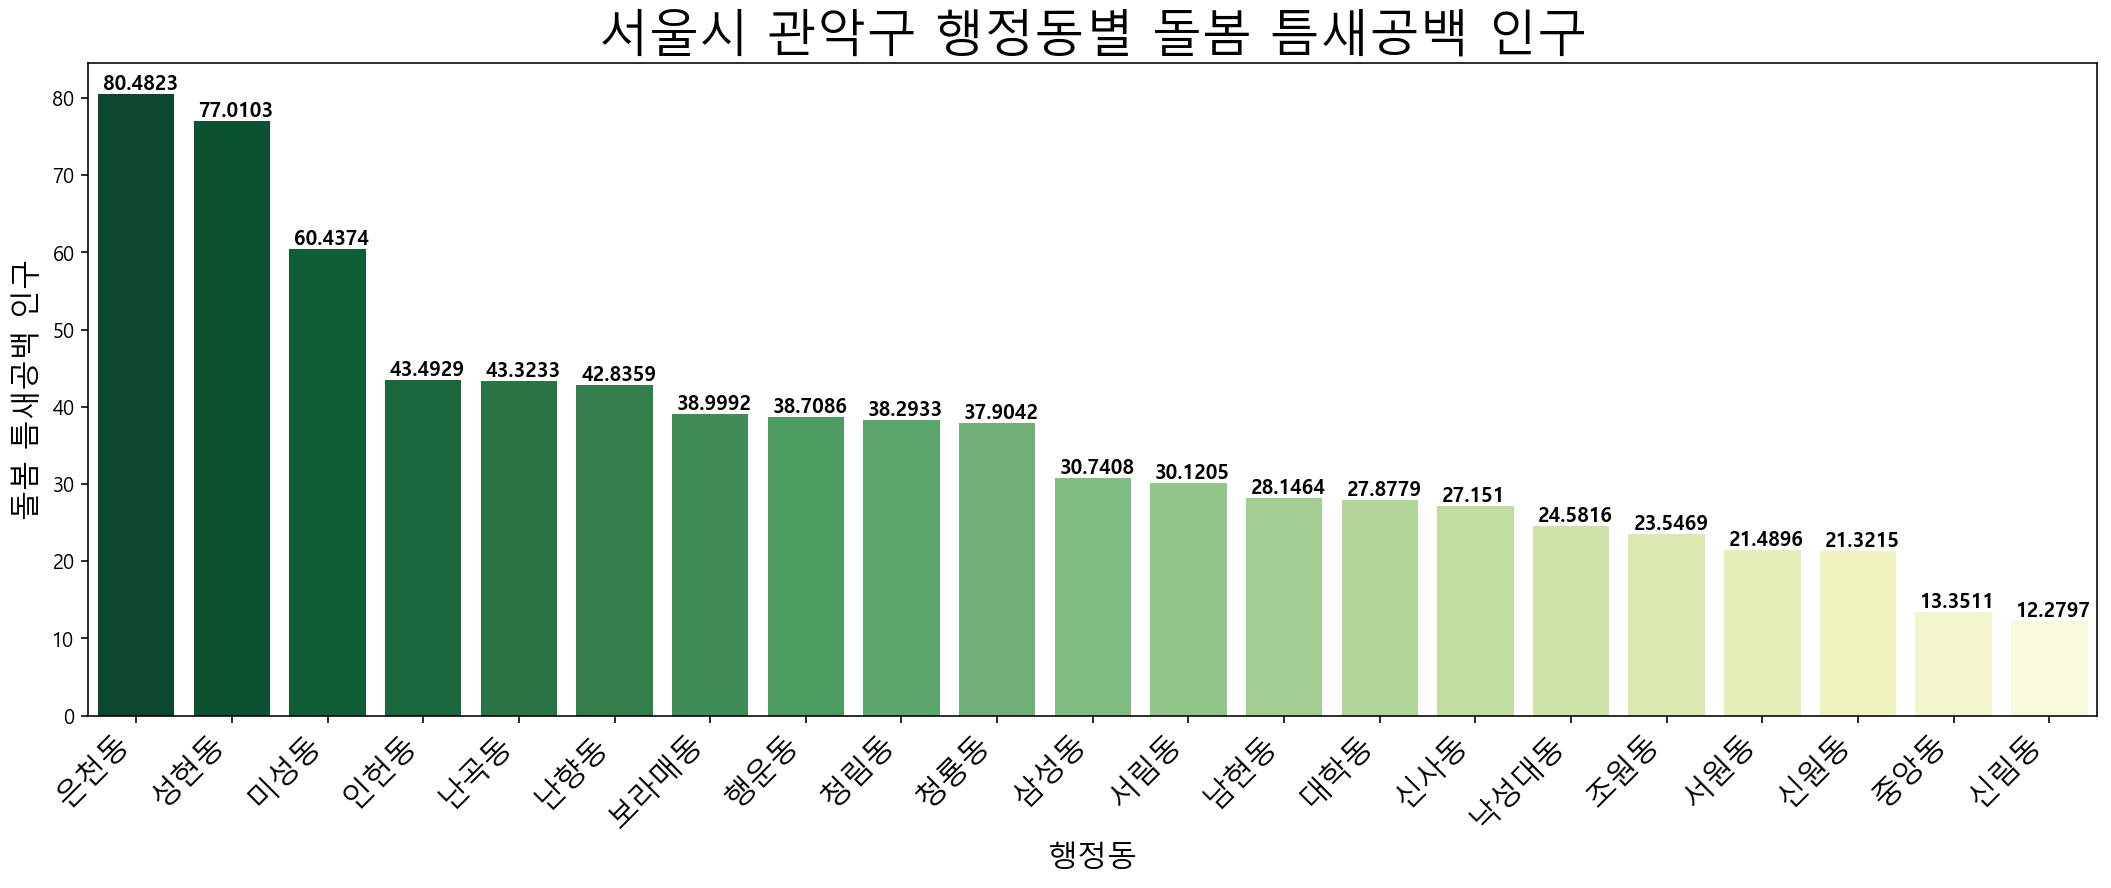

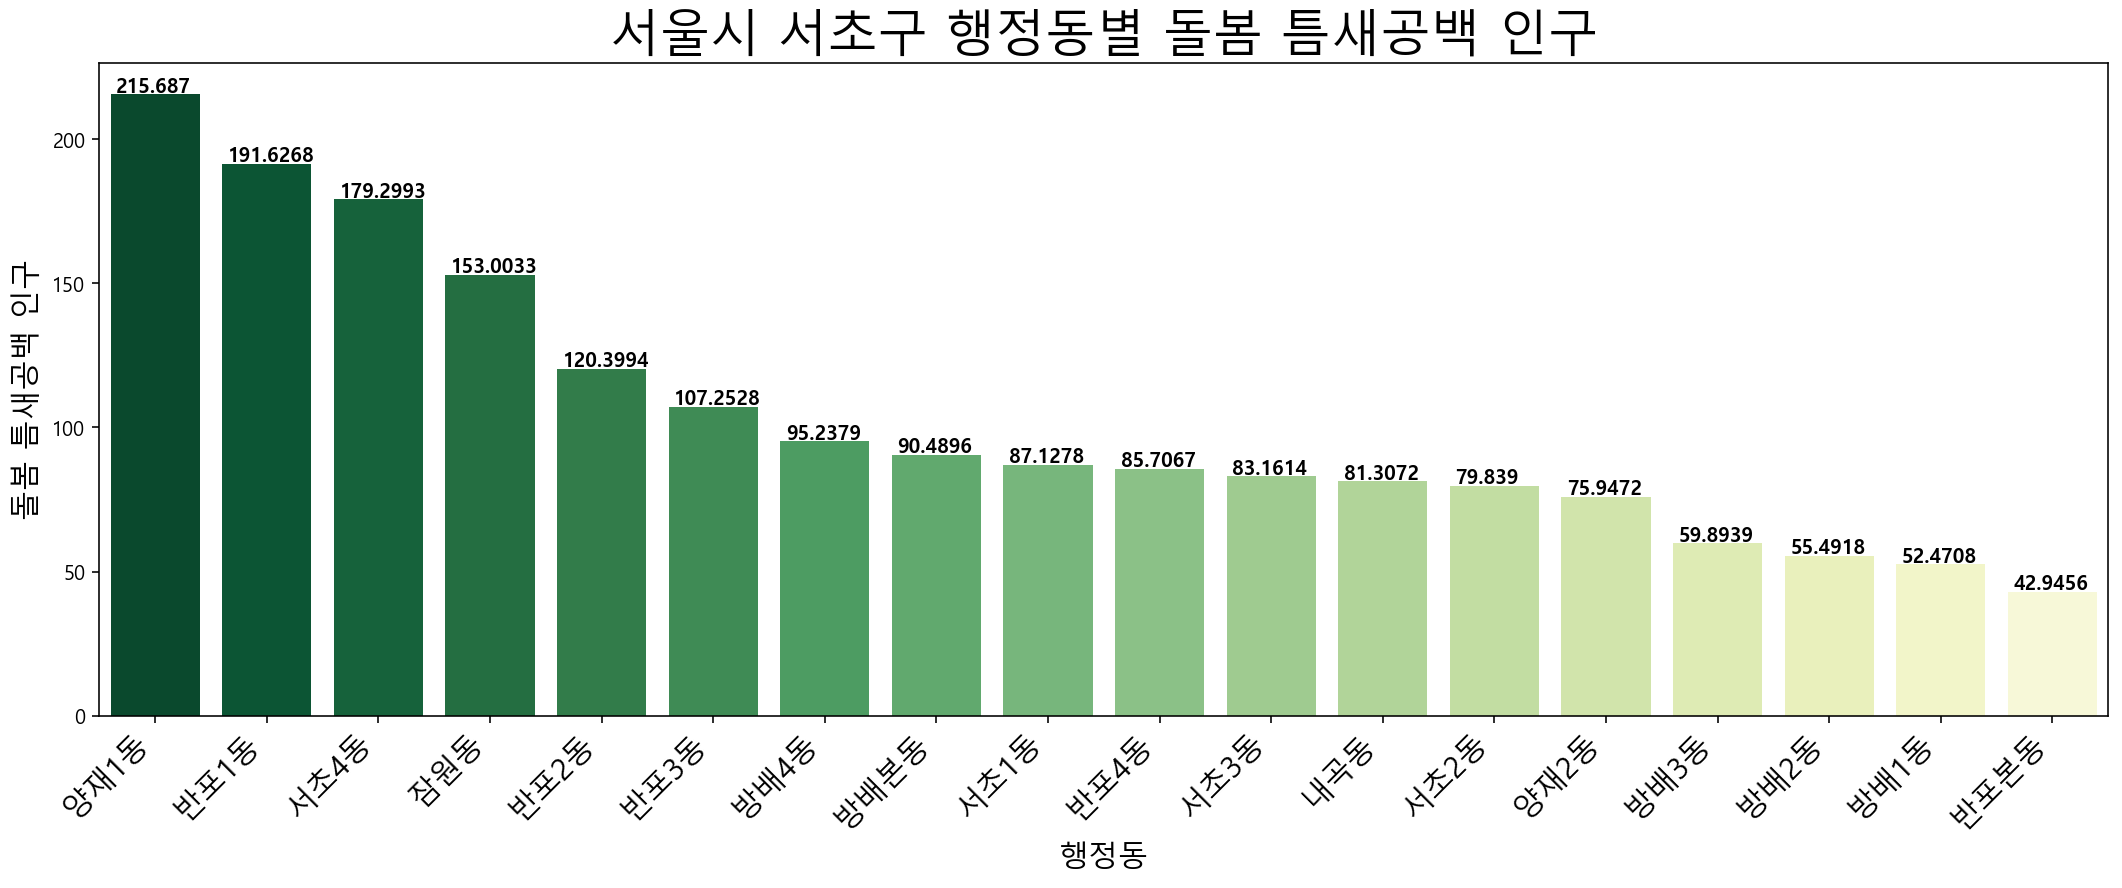

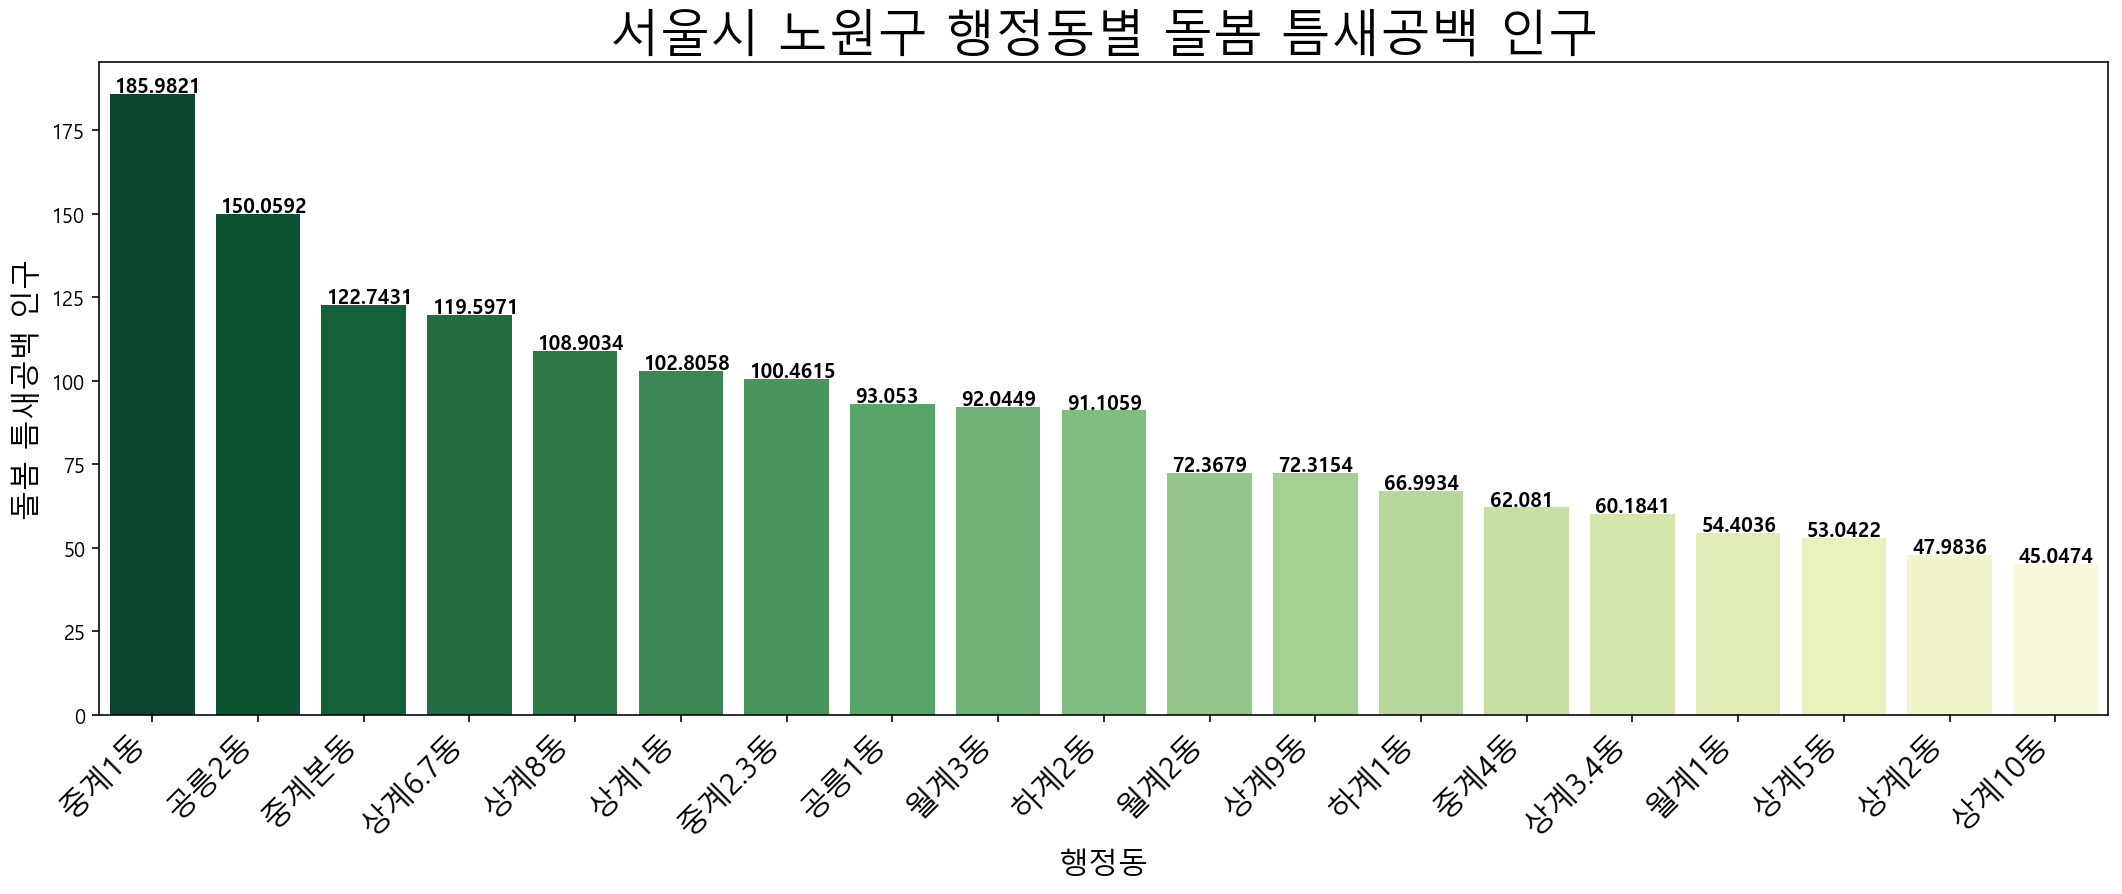

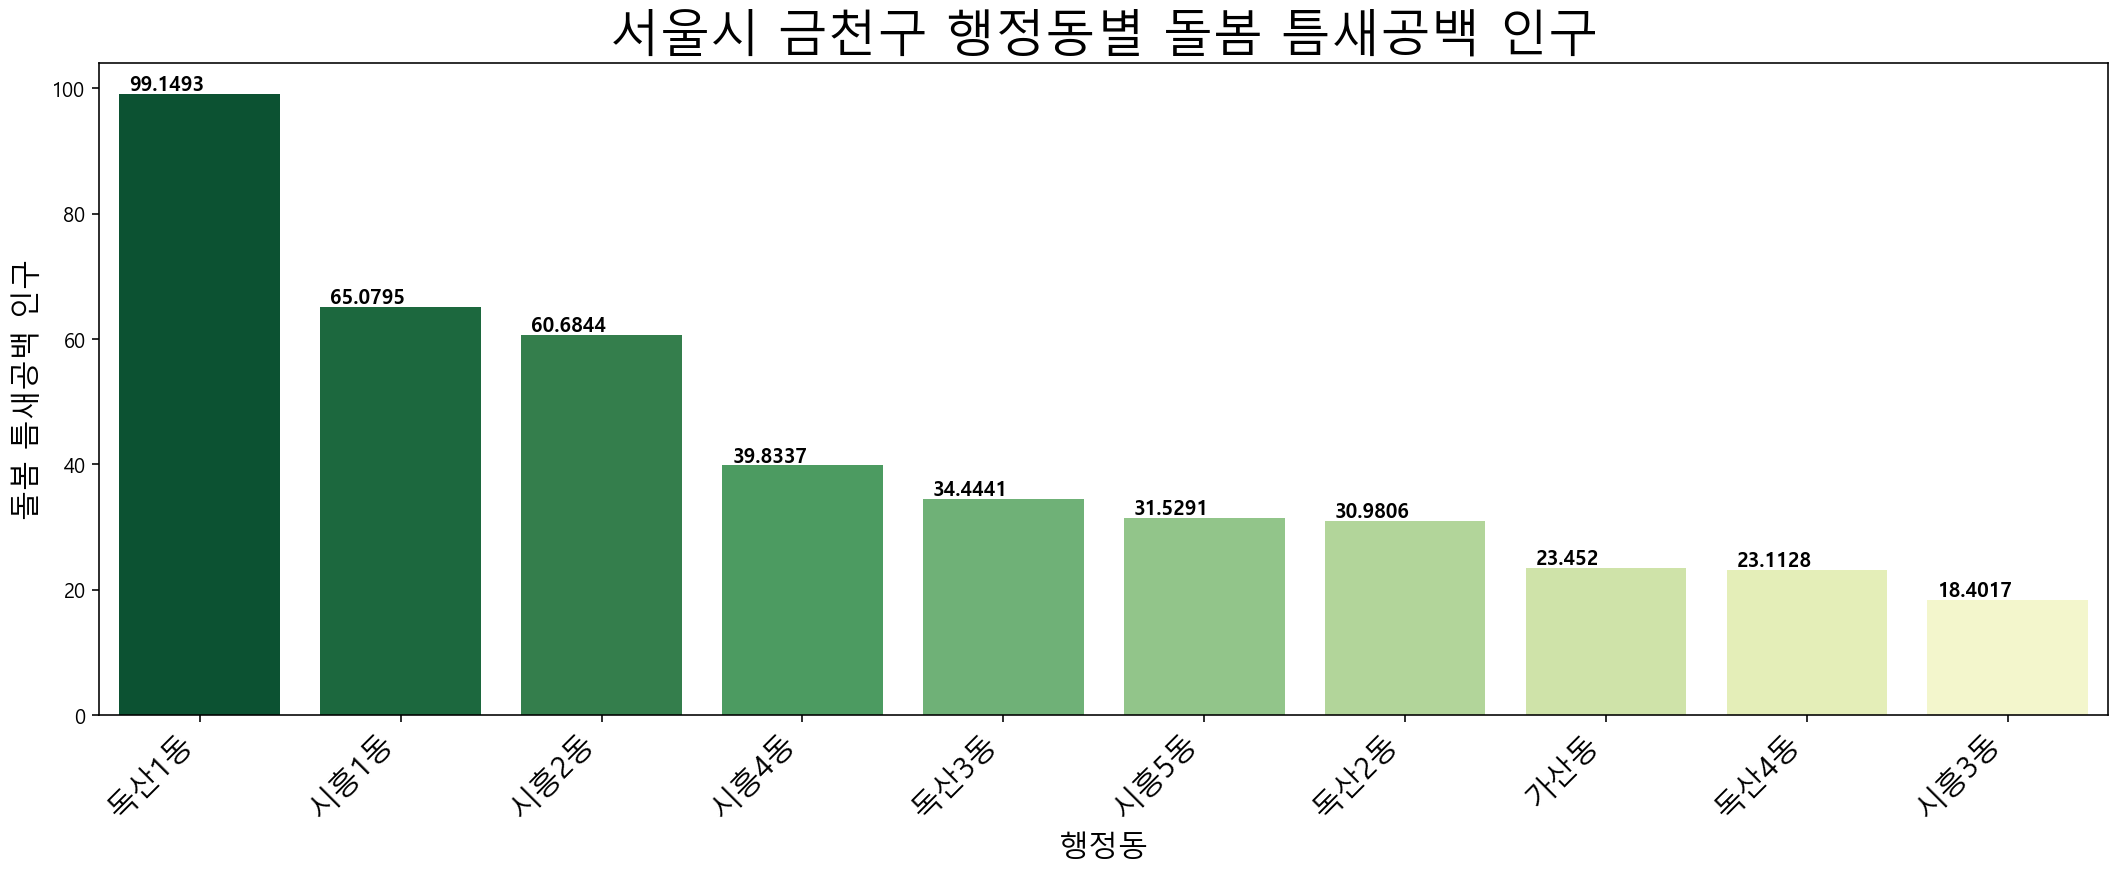

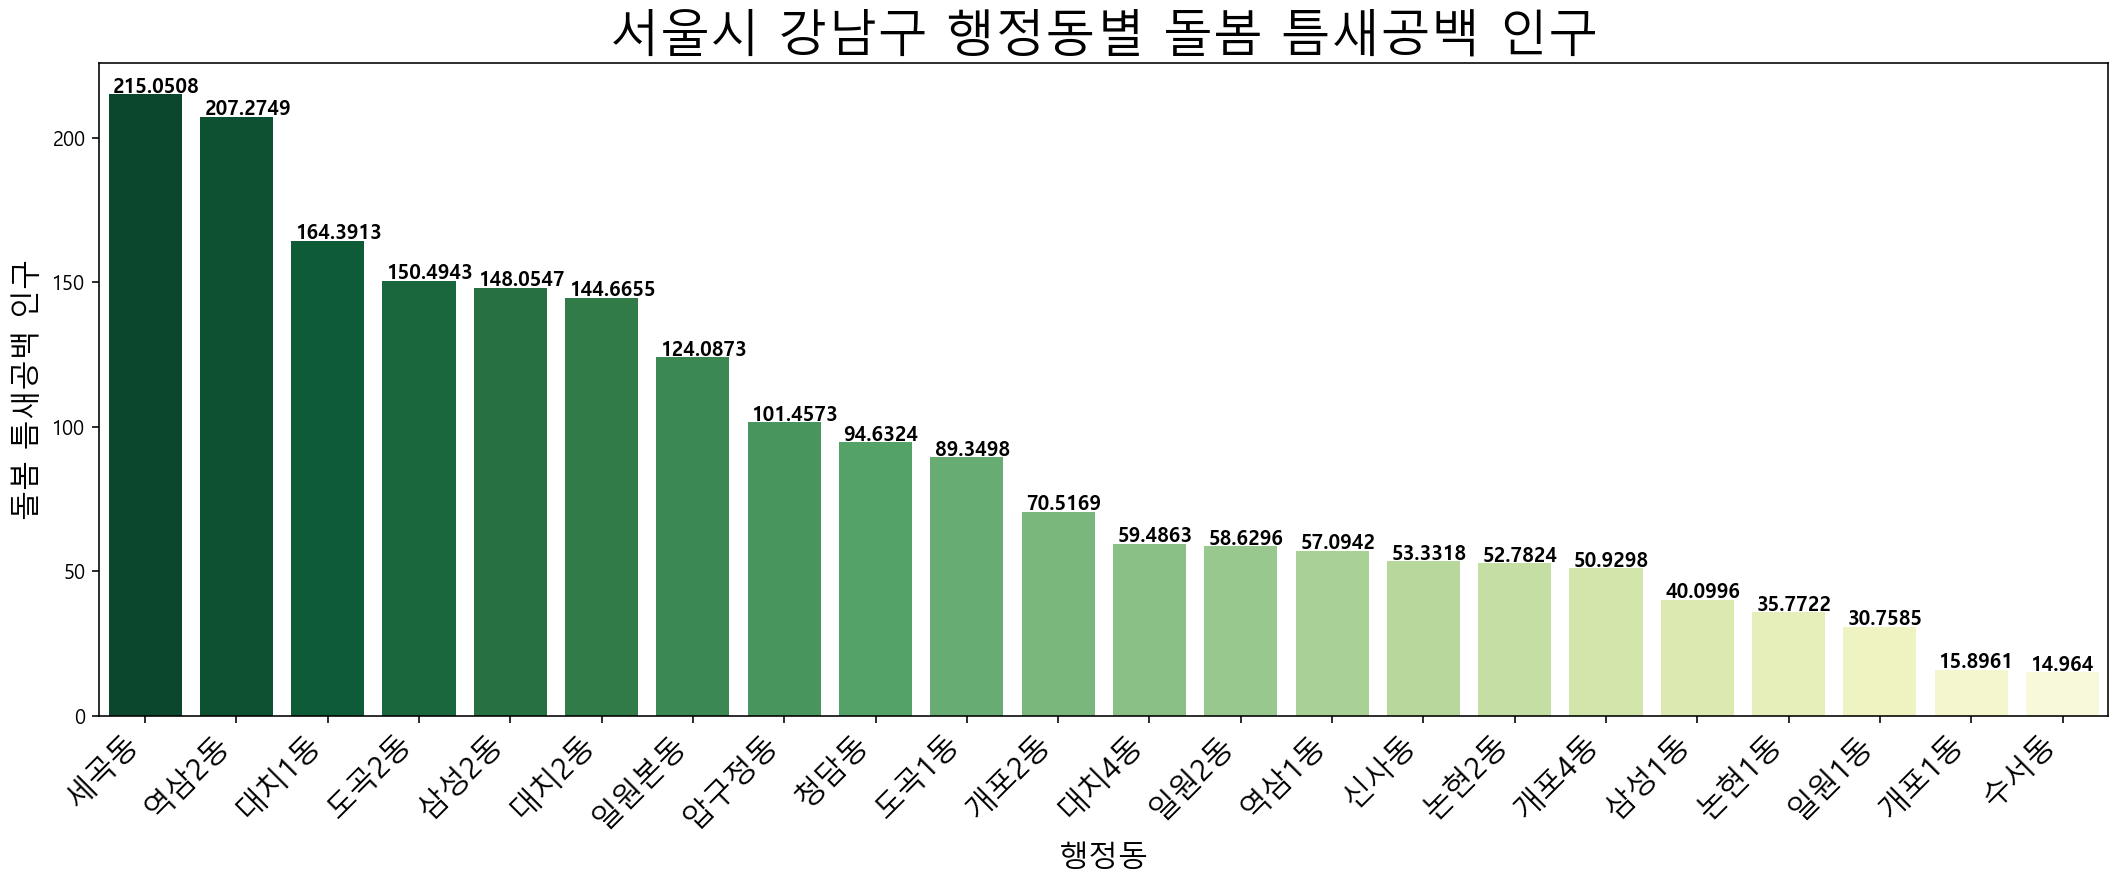

In [648]:
plot_dong_region(temp_df,'관악구','행정동')
plot_dong_region(temp_df,'서초구','행정동')
plot_dong_region(temp_df,'노원구','행정동')
plot_dong_region(temp_df,'금천구','행정동')
plot_dong_region(temp_df,'강남구','행정동')

In [649]:
# # 전체 구별 현황 그래프
# def plot_region(df, x_axis, rc, rot_x=True, show_xlabel=True):
#     plt.figure(figsize=(18, 6)) 

#     pal = sns.color_palette("Oranges_r", df.shape[0])
#     rank = df['돌봄 틈새공백  지수'].argsort().argsort()
#     sns.barplot(x=x_axis, y='돌봄 틈새공백  지수'.round(0), data=df, palette=np.array(pal[::-1])[rank])
#     for idx, score in enumerate(df['돌봄 틈새공백  지수']):
#         plt.text(idx-0.4, score+0.0005, score, size=10, weight='bold')
#     plt.title(f'서울시 시군구별 돌봄 틈새공백  지수', size=25)
# #     plt.legend(fontsize=15)
#     plt.ylabel(f'돌봄 틈새공백  지수', size=15)
#     if rot_x:
#         plt.xticks(rotation=45, size=15, ha='right')
#     if show_xlabel:
#         plt.xlabel(x_axis, size=15)
#     else:
#         plt.xlabel(None)

#     plt.show()

In [650]:
# tmp_list = []

# for gu in temp_df['시군구명'].unique():
#     tmp_df = temp_df[temp_df['시군구명']==gu]
#     tmp_list.append(round(tmp_df['돌봄 틈새공백  지수'].values[0],4))

# dmd_gu = pd.DataFrame({'시군구명':temp_df['시군구명'].unique(), '돌봄 틈새공백  지수':tmp_list})\
#                         .sort_values('돌봄 틈새공백  지수', ascending=False).reset_index(drop=True)
# plot_region(dmd_gu,'시군구명','돌봄 틈새공백  지수')

In [651]:
temp_df[temp_df['시군구명']=='금천구']

,행정동명,시군구명,돌봄 틈새공백 인구,동별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
397,시흥4동,금천구,39.833714,0.028372,7
398,시흥5동,금천구,31.529125,0.027877,8
399,시흥2동,금천구,60.684412,0.029022,4
400,독산2동,금천구,30.980628,0.028554,8
401,시흥1동,금천구,65.079490,0.030756,4
402,가산동,금천구,23.451975,0.037403,9
403,시흥3동,금천구,18.401674,0.028530,10
404,독산4동,금천구,23.112825,0.028186,9
405,독산3동,금천구,34.444094,0.029141,8
406,독산1동,금천구,99.149259,0.036439,2


In [652]:
# 평균 그래프
def plot_region_mean(df, x_axis, rc, rot_x=True, show_xlabel=True):
    plt.figure(figsize=(18, 6)) 

    pal = sns.color_palette("Oranges_r", df.shape[0])
    rank = df['동별 돌봄 틈새공백 인구 비율'].argsort().argsort()
    sns.barplot(x=x_axis, y='동별 돌봄 틈새공백 인구 비율', data=df, palette=np.array(pal[::-1])[rank])
    for idx, score in enumerate(df['동별 돌봄 틈새공백 인구 비율']):
        plt.text(idx-0.4, score+0.3, score, size=10, weight='bold')
    plt.title(f'서울시 시군구별 돌봄시설 동별 돌봄 틈새공백 인구 비율 평균', size=25)
#     plt.legend(fontsize=15)
    plt.ylabel(f'동별 돌봄 틈새공백 인구 비율', size=15)
    if rot_x:
        plt.xticks(rotation=45, size=15, ha='right')
    if show_xlabel:
        plt.xlabel(x_axis, size=15)
    else:
        plt.xlabel(None)

    plt.show()

In [655]:
temp_df

,행정동명,시군구명,돌봄 틈새공백 인구,동별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
0,후암동,용산구,38.804792,0.033891,7
1,원효로2동,용산구,37.046128,0.033405,7
2,이촌2동,용산구,16.602697,0.033677,10
3,이태원2동,용산구,16.220616,0.035886,10
4,서빙고동,용산구,38.576677,0.032692,7
...,...,...,...,...,...
419,송정동,성동구,19.064953,0.034289,9
420,성수2가1동,성동구,29.560791,0.034056,8
421,왕십리도선동,성동구,73.568696,0.037156,3
422,옥수동,성동구,87.779101,0.041057,3


0.035304622737794854

In [661]:
# 평균
tmp_list = []

for gu in temp_df['시군구명'].unique():
    tmp_df = temp_df[temp_df['시군구명']==gu]
    tmp_list.append(round(tmp_df['동별 돌봄 틈새공백 인구 비율'].mean(),4))

dmd_gu = pd.DataFrame({'시군구명':temp_df['시군구명'].unique(), '동별 돌봄 틈새공백 인구 비율':tmp_list})\
                        .sort_values('동별 돌봄 틈새공백 인구 비율', ascending=False).reset_index(drop=True)
                        
plot_region_mean(dmd_gu,'시군구명','동별 돌봄 틈새공백 인구 비율')

KeyError: '돌봄 틈새공백 인구 비율'

<Figure size 1296x432 with 0 Axes>

In [ ]:
# # 구별 max 값 시각화
# tmp_list = []

# for gu in temp_df['시군구명'].unique():
#     tmp_df = temp_df[temp_df['시군구명']==gu]
#     tmp_list.append(round(tmp_df['돌봄 틈새공백  인구'].values[0],0))

# dmd_gu = pd.DataFrame({'시군구명':temp_df['시군구명'].unique(), '돌봄 틈새공백  인구':tmp_list})\
#                         .sort_values('돌봄 틈새공백  인구', ascending=False).reset_index(drop=True)
# plot_region_mean(dmd_gu,'시군구명','돌봄 틈새공백  인구')

# 금천구의 지수 구하기

In [182]:
target = pklopen('금천구_초등학교881m_인구.pickle')
target

C:\anaconda3\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


,gid,행정동코드,시군구명,행정동,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry
0,다사44bb42ba,1154551000,금천구,가산동,[서울영일초등학교],1,0.0,346.0,95.0,684.0,126.876503,37.481217,POINT (126.87650 37.48122)
1,다사44bb42bb,1154551000,금천구,가산동,[서울영일초등학교],1,0.0,169.0,32.0,415.0,126.876485,37.483470,POINT (126.87648 37.48347)
2,다사45aa42ab,1154551000,금천구,가산동,[서울영일초등학교],1,0.0,0.0,0.0,0.0,126.879350,37.478979,POINT (126.87935 37.47898)
3,다사45aa42ba,1154551000,금천구,가산동,[서울영일초등학교],1,0.0,9.0,7.0,74.0,126.879331,37.481232,POINT (126.87933 37.48123)
4,다사45aa42bb,1154551000,금천구,가산동,[서울영일초등학교],1,0.0,0.0,0.0,0.0,126.879312,37.483485,POINT (126.87931 37.48349)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,다사48bb39ba,1154568000,금천구,시흥제2동,"[서울금천초등학교, 서울탑동초등학교, 동광초등학교]",3,0.0,0.0,0.0,0.0,126.921952,37.454407,POINT (126.92195 37.45441)
190,다사48bb39bb,1154568000,금천구,시흥제2동,"[서울금천초등학교, 서울탑동초등학교, 동광초등학교, 서울난향초등학교]",4,0.0,0.0,0.0,0.0,126.921934,37.456661,POINT (126.92193 37.45666)
191,다사49aa38bb,1154568000,금천구,시흥제2동,"[서울금동초등학교, 동광초등학교]",2,0.0,0.0,0.0,0.0,126.924830,37.447661,POINT (126.92483 37.44766)
192,다사49aa39aa,1154568000,금천구,시흥제2동,"[서울금동초등학교, 동광초등학교]",2,0.0,0.0,0.0,0.0,126.924813,37.449914,POINT (126.92481 37.44991)


In [204]:
target.columns = ['gid', '행정동코드', '시군구명', '행정동명', '학교명', '학교개수', '초등학생_인구', '30대_인구',
       '40대_인구', '전체_인구', '경도', '위도', 'geometry']
target

['행정동코드', '시군구명', '행정동명', '0514세 인구', '3040세 인구', '총거주인구', '3040대 결혼율',
       '3040세 기혼인구', '3040세 맞벌이 기혼인구', '3040세 인구별 맞벌이 기혼비율지수(맞벌이 기혼인구/총거주인구)',
       '초등돌봄 인구지수(인구별)', '돌봄 틈새공백  인구지수', 'new돌봄 틈새공백  인구지수', '초등돌봄틈새 분위',
       '동별 돌봄 틈새공백  인구지수', '동별 돌봄 틈새공백  인구지수 분위']

,gid,행정동코드,시군구명,행정동명,학교명,학교개수,초등학생_인구,30대_인구,40대_인구,전체_인구,경도,위도,geometry
0,다사44bb42ba,1154551000,금천구,가산동,[서울영일초등학교],1,0.0,346.0,95.0,684.0,126.876503,37.481217,POINT (126.87650 37.48122)
1,다사44bb42bb,1154551000,금천구,가산동,[서울영일초등학교],1,0.0,169.0,32.0,415.0,126.876485,37.483470,POINT (126.87648 37.48347)
2,다사45aa42ab,1154551000,금천구,가산동,[서울영일초등학교],1,0.0,0.0,0.0,0.0,126.879350,37.478979,POINT (126.87935 37.47898)
3,다사45aa42ba,1154551000,금천구,가산동,[서울영일초등학교],1,0.0,9.0,7.0,74.0,126.879331,37.481232,POINT (126.87933 37.48123)
4,다사45aa42bb,1154551000,금천구,가산동,[서울영일초등학교],1,0.0,0.0,0.0,0.0,126.879312,37.483485,POINT (126.87931 37.48349)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,다사48bb39ba,1154568000,금천구,시흥제2동,"[서울금천초등학교, 서울탑동초등학교, 동광초등학교]",3,0.0,0.0,0.0,0.0,126.921952,37.454407,POINT (126.92195 37.45441)
190,다사48bb39bb,1154568000,금천구,시흥제2동,"[서울금천초등학교, 서울탑동초등학교, 동광초등학교, 서울난향초등학교]",4,0.0,0.0,0.0,0.0,126.921934,37.456661,POINT (126.92193 37.45666)
191,다사49aa38bb,1154568000,금천구,시흥제2동,"[서울금동초등학교, 동광초등학교]",2,0.0,0.0,0.0,0.0,126.924830,37.447661,POINT (126.92483 37.44766)
192,다사49aa39aa,1154568000,금천구,시흥제2동,"[서울금동초등학교, 동광초등학교]",2,0.0,0.0,0.0,0.0,126.924813,37.449914,POINT (126.92481 37.44991)


In [579]:
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 맞벌이 기혼인구,행정동별 3040세 맞벌이 기혼인구 비율,초등돌봄필요 인구,돌봄 틈새공백 인구,동별 돌봄 틈새공백 인구 비율,돌봄틈새 분위,돌봄틈새공백 분위
0,1117051000,용산구,후암동,1145,5627,17804,0.593661,3340.529908,1660.243364,0.093251,106.772560,38.804792,0.033891,0,7
1,1117057000,용산구,원효로2동,1109,4466,14336,0.593661,2651.289598,1317.690930,0.091915,101.933541,37.046128,0.033405,0,7
2,1117064000,용산구,이촌2동,493,2770,8820,0.593661,1644.440705,817.287030,0.092663,45.682824,16.602697,0.033677,0,10
3,1117066000,용산구,이태원2동,452,3103,9272,0.593661,1842.129786,915.538504,0.098742,44.631515,16.220616,0.035886,0,10
4,1117069000,용산구,서빙고동,1180,4071,13353,0.593661,2416.793541,1201.146390,0.089953,106.144892,38.576677,0.032692,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,1120072000,성동구,송정동,556,3308,10945,0.628100,2077.756347,1032.644905,0.094349,52.457795,19.064953,0.034289,0,9
420,1120067000,성동구,성수2가1동,868,5104,17003,0.628100,3205.824787,1593.294919,0.093707,81.337410,29.560791,0.034056,0,8
421,1120053500,성동구,왕십리도선동,1980,8933,27276,0.628100,5610.821478,2788.578274,0.102236,202.426492,73.568696,0.037156,0,3
422,1120064500,성동구,옥수동,2138,9738,26909,0.628100,6116.442354,3039.871850,0.112969,241.526850,87.779101,0.041057,0,3


# 금천구만 시각화

In [171]:
pt_list = np.percentile(final_df[['동별 돌봄 틈새공백 인구지수']],[i*10 for i in range(1,10)]).tolist()
pt_list

[0.041625229915141504,
 0.04449428606206213,
 0.046436398568950085,
 0.048262775514099826,
 0.050323997869990617,
 0.05207842966435936,
 0.05359540795648204,
 0.05574155738416331,
 0.059909127751037794]

In [172]:
# 동별 돌봄 틈새공백  인구지수 분위 라벨링
final_df['동별 돌봄 틈새공백  인구지수 분위'] = 0
final_df.loc[final_df['동별 돌봄 틈새공백  인구지수'] <= pt_list[0], '동별 돌봄 틈새공백  인구지수 분위'] = 10
final_df.loc[(final_df['동별 돌봄 틈새공백  인구지수'] > pt_list[0]) & (final_df['동별 돌봄 틈새공백  인구지수'] <= pt_list[1]),'동별 돌봄 틈새공백  인구지수 분위'] = 9
final_df.loc[(final_df['동별 돌봄 틈새공백  인구지수'] > pt_list[1]) & (final_df['동별 돌봄 틈새공백  인구지수'] <= pt_list[2]),'동별 돌봄 틈새공백  인구지수 분위'] = 8
final_df.loc[(final_df['동별 돌봄 틈새공백  인구지수'] > pt_list[2]) & (final_df['동별 돌봄 틈새공백  인구지수'] <= pt_list[3]),'동별 돌봄 틈새공백  인구지수 분위'] = 7
final_df.loc[(final_df['동별 돌봄 틈새공백  인구지수'] > pt_list[3]) & (final_df['동별 돌봄 틈새공백  인구지수'] <= pt_list[4]),'동별 돌봄 틈새공백  인구지수 분위'] = 6
final_df.loc[(final_df['동별 돌봄 틈새공백  인구지수'] > pt_list[4]) & (final_df['동별 돌봄 틈새공백  인구지수'] <= pt_list[5]),'동별 돌봄 틈새공백  인구지수 분위'] = 5
final_df.loc[(final_df['동별 돌봄 틈새공백  인구지수'] > pt_list[5]) & (final_df['동별 돌봄 틈새공백  인구지수'] <= pt_list[6]),'동별 돌봄 틈새공백  인구지수 분위'] = 4
final_df.loc[(final_df['동별 돌봄 틈새공백  인구지수'] > pt_list[6]) & (final_df['동별 돌봄 틈새공백  인구지수'] <= pt_list[7]),'동별 돌봄 틈새공백  인구지수 분위'] = 3
final_df.loc[(final_df['동별 돌봄 틈새공백  인구지수'] > pt_list[7]) & (final_df['동별 돌봄 틈새공백  인구지수'] <= pt_list[8]),'동별 돌봄 틈새공백  인구지수 분위'] = 2
final_df.loc[(final_df['동별 돌봄 틈새공백  인구지수'] > pt_list[8]),'동별 돌봄 틈새공백  인구지수 분위'] = 1
final_df

,행정동코드,시군구명,행정동명,0514세 인구,3040세 인구,총거주인구,3040대 결혼율,3040세 기혼인구,3040세 맞벌이 기혼인구,3040세 인구별 맞벌이 기혼비율지수(맞벌이 기혼인구/총거주인구),초등돌봄필요인구지수(인구별),틈새돌봄 필요인구지수,new틈새돌봄 필요인구지수,초등돌봄틈새필요분위,동별 틈새돌봄 필요인구지수,동별 틈새돌봄 필요인구지수 분위
0,1111053000,종로구,사직동,704,2903,9481,58.89,1710.0,850.0,8.97,6315,33.0,2295.0,9,0.046875,7
1,1111054000,종로구,삼청동,165,748,2718,58.89,440.0,219.0,8.06,1330,7.0,483.0,10,0.042424,9
2,1111055000,종로구,부암동,815,2884,10093,58.89,1698.0,844.0,8.36,6813,35.0,2476.0,9,0.042945,9
3,1111056000,종로구,평창동,1413,5063,18523,58.89,2982.0,1482.0,8.00,11304,59.0,4108.0,7,0.041755,9
4,1111057000,종로구,무악동,925,2558,8684,58.89,1506.0,748.0,8.61,7964,41.0,2894.0,8,0.044324,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,1174069000,강동구,둔촌1동,11,78,263,65.26,51.0,25.0,9.51,105,1.0,38.0,10,0.090909,1
420,1174070000,강동구,둔촌2동,2049,8081,27214,65.26,5274.0,2621.0,9.63,19732,103.0,7171.0,4,0.050268,6
421,1174057000,강동구,암사1동,2453,11243,35974,65.26,7337.0,3646.0,10.14,24873,129.0,9039.0,2,0.052589,4
422,1174061000,강동구,천호2동,1710,11353,34852,65.26,7409.0,3682.0,10.56,18058,94.0,6562.0,4,0.054971,3


In [193]:
temp_df = final_df[['행정동명','시군구명','동별 돌봄 틈새공백  인구지수']]
#스케일링
temp_df['동별 돌봄 틈새공백  인구지수'] = temp_df['동별 돌봄 틈새공백  인구지수']*10000

temp_df

<ipython-input-193-deb6e2432134>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['동별 틈새돌봄 필요인구지수'] = temp_df['동별 틈새돌봄 필요인구지수']*10000


,행정동명,시군구명,동별 틈새돌봄 필요인구지수
0,사직동,종로구,468.750000
1,삼청동,종로구,424.242424
2,부암동,종로구,429.447853
3,평창동,종로구,417.551309
4,무악동,종로구,443.243243
...,...,...,...
419,둔촌1동,강동구,909.090909
420,둔촌2동,강동구,502.684236
421,암사1동,강동구,525.886669
422,천호2동,강동구,549.707602


In [194]:
# 평균 그래프
def plot_region_mean(df, x_axis, rc, rot_x=True, show_xlabel=True):
    plt.figure(figsize=(18, 6)) 

    pal = sns.color_palette("Oranges_r", df.shape[0])
    rank = df['동별 돌봄 틈새공백  인구지수'].argsort().argsort()
    sns.barplot(x=x_axis, y='동별 돌봄 틈새공백  인구지수', data=df, palette=np.array(pal[::-1])[rank])
    for idx, score in enumerate(df['동별 돌봄 틈새공백  인구지수']):
        plt.text(idx-0.4, score+0.3, score, size=10, weight='bold')
    plt.title(f'서울시 시군구별 돌봄시설 동별 돌봄 틈새공백  인구지수 평균', size=25)
#     plt.legend(fontsize=15)
    plt.ylabel(f'동별 돌봄 틈새공백  인구지수', size=15)
    if rot_x:
        plt.xticks(rotation=45, size=15, ha='right')
    if show_xlabel:
        plt.xlabel(x_axis, size=15)
    else:
        plt.xlabel(None)

    plt.show()

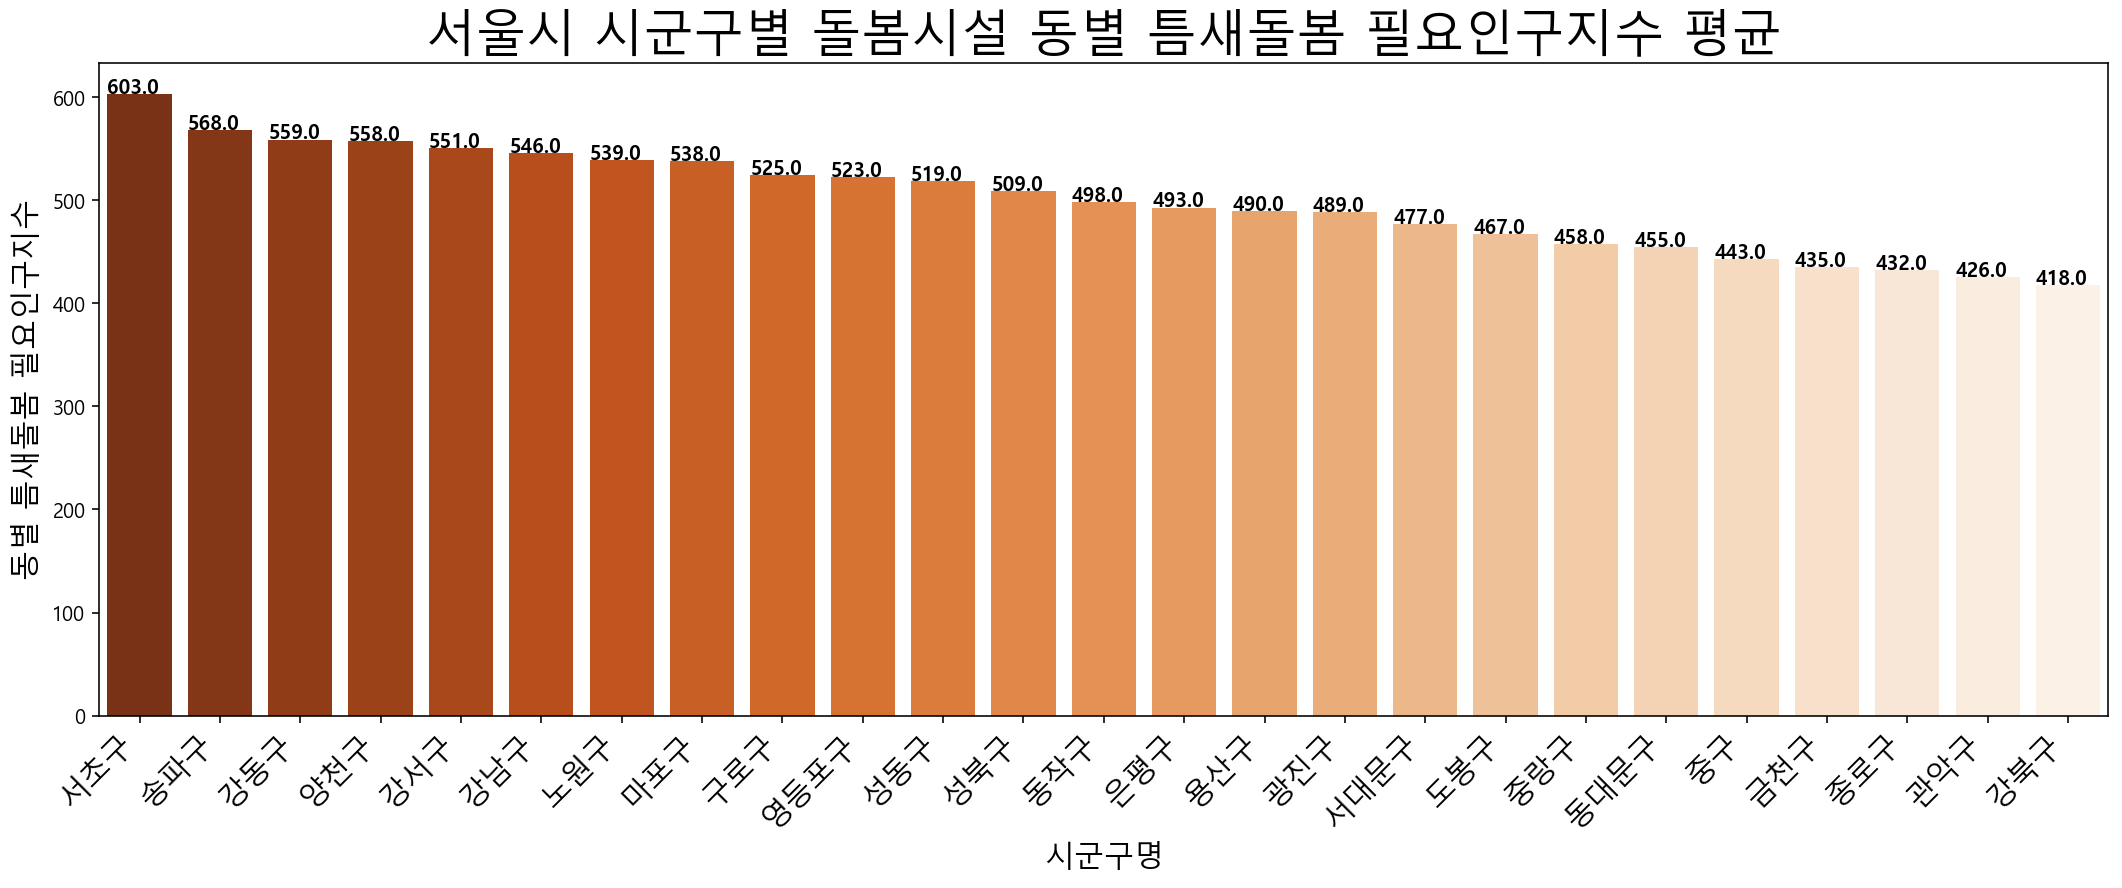

In [195]:
# 평균
tmp_list = []

for gu in temp_df['시군구명'].unique():
    tmp_df = temp_df[temp_df['시군구명']==gu]
    tmp_list.append(round(tmp_df['동별 돌봄 틈새공백  인구지수'].mean(),0))

dmd_gu = pd.DataFrame({'시군구명':temp_df['시군구명'].unique(), '동별 돌봄 틈새공백  인구지수':tmp_list})\
                        .sort_values('동별 돌봄 틈새공백  인구지수', ascending=False).reset_index(drop=True)
                        
plot_region_mean(dmd_gu,'시군구명','동별 돌봄 틈새공백  인구지수')

<AxesSubplot:>

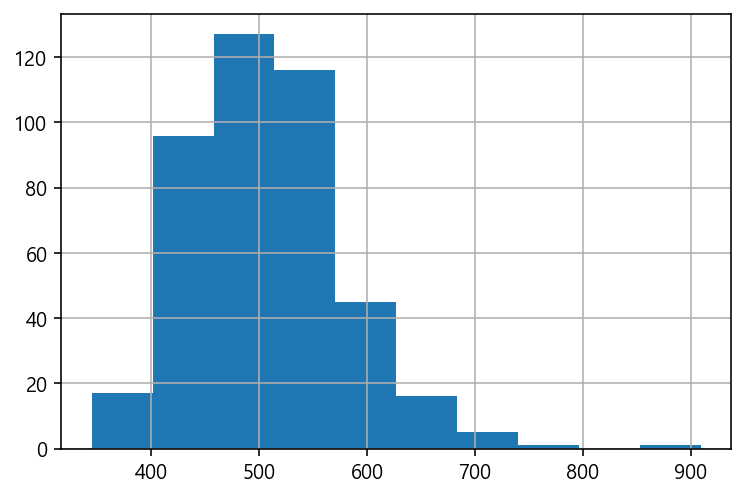

In [200]:
temp_df['동별 돌봄 틈새공백  인구지수'].hist()